# MHC Genomics Analysis Project
## Comprehensive Pipeline for HLA Allele Typing and Quality Assessment

**Objective:** Analyze NGS data from the MHC region to characterize genetic diversity, assess sequencing quality, and perform HLA allele typing

---

## Project Overview

The Major Histocompatibility Complex (MHC) on chromosome 6 contains critical immune system genes. This analysis pipeline processes 80 BAM files to:
1. Annotate reads with gene information
2. Assess sequencing and mapping quality
3. Extract and type HLA alleles through sequence alignment

## Environment Setup and Dependencies

In [1]:
# !pip install pysam biopython pandas numpy matplotlib seaborn scipy

import os
import sys
import glob
import warnings
warnings.filterwarnings('ignore')

# Core bioinformatics libraries
import pysam
from Bio import SeqIO, Seq, AlignIO, pairwise2
from Bio.Align import PairwiseAligner
from Bio.SeqRecord import SeqRecord

# Data manipulation and analysis
import pandas as pd
import numpy as np
from collections import defaultdict, Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Scientific computing
from scipy import stats
from scipy.stats import gaussian_kde

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries loaded successfully")
print(f"Python version: {sys.version}")
print(f"Pysam version: {pysam.__version__}")

✓ All libraries loaded successfully
Python version: 3.14.0 (main, Oct  7 2025, 09:34:52) [Clang 17.0.0 (clang-1700.3.19.1)]
Pysam version: 0.23.3


## Configuration and File Paths

In [ ]:
# Configure directory structure
BASE_DIR = os.getcwd()
BAM_DIR = "bam_files"  
GTF_FILE = "gencode.v19.annotation.gtf" 
OUTPUT_DIR = "results"
FASTA_REF = "reference_genome.fa"  

# Create output directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/task1_annotations", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/task2_quality", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/task3_mhc_typing", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/sequences", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/figures", exist_ok=True)

# MHC gene definitions
MHC_CLASS_I = ['HLA-A', 'HLA-B', 'HLA-C', 'HLA-E', 'HLA-F', 'HLA-G']
MHC_CLASS_II = ['HLA-DRA', 'HLA-DRB1', 'HLA-DRB3', 'HLA-DRB4', 'HLA-DRB5',
                'HLA-DQA1', 'HLA-DQB1', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DMA',
                'HLA-DMB', 'HLA-DOA', 'HLA-DOB']
MHC_CLASS_III = ['C2', 'C4A', 'C4B', 'CFB', 'TNF', 'LTA', 'LTB', 'HSPA1A',
                 'HSPA1B', 'MICA', 'MICB']

MHC_GENES = MHC_CLASS_I + MHC_CLASS_II + MHC_CLASS_III

print(f"Configuration complete")
print(f"BAM directory: {BAM_DIR}")
print(f"GTF file: {GTF_FILE}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"\nMHC genes to analyze: {len(MHC_GENES)} genes")

Configuration complete
BAM directory: bam_files
GTF file: gencode.v19.annotation.gtf
Output directory: results

MHC genes to analyze: 30 genes


---
# Task 1: BAM File Annotation with GTF

**Objective:** Parse GTF annotations and map aligned reads to genes, extracting gene coordinates and sequences.

**Scientific Rationale:** Gene annotation allows identification of which genomic regions are covered by sequencing reads, essential for understanding which immune genes are represented in the dataset.

## 1.1 Parse GTF Annotation File

In [3]:
def parse_gtf(gtf_file):
    """
    Parse GTF file and extract gene-level annotations.
    
    Parameters:
    -----------
    gtf_file : str
        Path to GTF annotation file
    
    Returns:
    --------
    dict : Dictionary with gene_name as key and gene info as value
    """
    print("Parsing GTF file...")
    gene_dict = {}
    
    with open(gtf_file, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            
            fields = line.strip().split('\t')
            if len(fields) < 9:
                continue
            
            feature_type = fields[2]
            
            # Extract gene-level features
            if feature_type == 'gene':
                chrom = fields[0]
                start = int(fields[3])
                end = int(fields[4])
                strand = fields[6]
                attributes = fields[8]
                
                # Parse attributes
                attr_dict = {}
                for attr in attributes.split(';'):
                    attr = attr.strip()
                    if attr:
                        key_val = attr.split(' ', 1)
                        if len(key_val) == 2:
                            key, val = key_val
                            attr_dict[key] = val.strip('"')
                
                gene_name = attr_dict.get('gene_name', attr_dict.get('gene_id', 'Unknown'))
                gene_id = attr_dict.get('gene_id', '')
                
                gene_dict[gene_name] = {
                    'gene_name': gene_name,
                    'gene_id': gene_id,
                    'chromosome': chrom,
                    'start': start,
                    'end': end,
                    'strand': strand,
                    'length': end - start + 1
                }
    
    print(f"✓ Parsed {len(gene_dict)} genes from GTF")
    return gene_dict

# Parse GTF annotation
gene_annotations = parse_gtf(GTF_FILE)

# Display sample annotations
print("Number of genes parsed:", len(gene_annotations))
for i, (gene, info) in enumerate(list(gene_annotations.items())[:5]):
    print(f"{gene}: chr{info['chromosome']}:{info['start']}-{info['end']} ({info['strand']})")

Parsing GTF file...
✓ Parsed 55765 genes from GTF
Number of genes parsed: 55765
DDX11L1: chrchr1:11869-14412 (+)
WASH7P: chrchr1:14363-29806 (-)
MIR1302-11: chrchr1:29554-31109 (+)
FAM138A: chrchr1:34554-36081 (-)
OR4G4P: chrchr1:52473-54936 (+)


In [4]:
def normalize_chrom(chrom, bam_refs):
    """
    Standardizes chromosome names to match the BAM file.
    Example: Converts 'chr6' -> '6' if the BAM uses '6'.
    """
    if chrom in bam_refs: return chrom
    # Try removing 'chr'
    if chrom.startswith("chr"):
        c = chrom[3:]
        if c in bam_refs: return c
    # Try adding 'chr'
    if not chrom.startswith("chr"):
        c = "chr" + chrom
        if c in bam_refs: return c
    return chrom
def count_reads_per_gene(bam_file, gene_dict):
    """
    Count reads mapping to each gene region (with chromosome name normalization).
    """
    bamfile = pysam.AlignmentFile(bam_file, "rb")
    bam_refs = list(bamfile.references)
    gene_counts = defaultdict(int)

    for gene_name, info in gene_dict.items():
        try:
            chrom = normalize_chrom(info["chromosome"], bam_refs)
            start = info["start"] - 1
            end = info["end"]
            count = bamfile.count(chrom, start, end)
            gene_counts[gene_name] = count
        except Exception:
            gene_counts[gene_name] = 0

    bamfile.close()
    return gene_counts

In [5]:
import pysam, glob, os

bam_paths = glob.glob(os.path.join(BAM_DIR, "*.bam"))
for bam in bam_paths:
    bai = bam + ".bai"
    if not os.path.exists(bai):
        print("Indexing", bam)
        pysam.index(bam)
    else:
        print("Already indexed", bam)

Already indexed bam_files/MOT36424.bam
Already indexed bam_files/MOT36430.bam
Already indexed bam_files/MOT36426.bam
Already indexed bam_files/MOT36432.bam
Already indexed bam_files/MOT36433.bam
Already indexed bam_files/MOT36427.bam
Already indexed bam_files/MOT36437.bam
Already indexed bam_files/MOT36436.bam
Already indexed bam_files/MOT36434.bam
Already indexed bam_files/MOT36435.bam
Already indexed bam_files/MOT36446.bam
Already indexed bam_files/MOT36447.bam
Already indexed bam_files/MOT36440.bam
Already indexed bam_files/MOT36441.bam
Already indexed bam_files/MOT36443.bam
Already indexed bam_files/MOT36442.bam
Already indexed bam_files/MOT36449.bam
Already indexed bam_files/MOT36438.bam
Already indexed bam_files/MOT36439.bam
Already indexed bam_files/MOT36428.bam


## 1.2 Extract Gene Sequences from Reference Genome

In [ ]:
def extract_gene_sequences(gene_dict, fasta_ref):
    """
    Extract genomic sequences for each gene from reference genome.
    Includes automatic chromosome name fixing (e.g., chr6 -> 6).
    """
    print(f"Extracting gene sequences from {os.path.basename(fasta_ref)}...")
    
    if not os.path.exists(fasta_ref):
        print("⚠ Error: Reference genome file not found.")
        return gene_dict

    # Open reference genome
    fasta = pysam.FastaFile(fasta_ref)
    
    # Get list of chromosomes actually in the file (e.g., ['1', '2', '6'] or ['chr1', ...])
    valid_chroms = set(fasta.references)
    print(f"Reference genome chromosome format: {list(valid_chroms)[:5]}...")
    
    success_count = 0
    
    for gene_name, info in gene_dict.items():
        try:
            target_chrom = info['chromosome']
            
            # --- Normalize Chromosome Name ---
            if target_chrom not in valid_chroms:
                # Case 1: GTF has 'chr6', FASTA has '6'
                if target_chrom.startswith('chr') and target_chrom[3:] in valid_chroms:
                    target_chrom = target_chrom[3:]
                # Case 2: GTF has '6', FASTA has 'chr6'
                elif ('chr' + target_chrom) in valid_chroms:
                    target_chrom = 'chr' + target_chrom
            
            # If still not found, skip
            if target_chrom not in valid_chroms:
                # Only print warning for the first few to avoid spamming
                if success_count == 0: 
                    print(f"Warning: Chromosome '{info['chromosome']}' not found in FASTA (Available: {list(valid_chroms)[:3]}...)")
                continue

            # Fetch sequence
            start = info['start'] - 1  # Convert to 0-based
            end = info['end']
            
            sequence = fasta.fetch(target_chrom, start, end)
            
            # Reverse complement if on negative strand
            if info['strand'] == '-':
                sequence = str(Seq.Seq(sequence).reverse_complement())
            
            gene_dict[gene_name]['sequence'] = sequence
            success_count += 1
            
        except Exception as e:
            gene_dict[gene_name]['sequence'] = 'N/A'
    
    fasta.close()
    print(f"✓ Successfully extracted sequences for {success_count} genes")
    return gene_dict

# Re-run the extraction
if os.path.exists(FASTA_REF):
    gene_annotations = extract_gene_sequences(gene_annotations, FASTA_REF)

Extracting gene sequences from reference_genome.fa...
Reference genome chromosome format: ['15', 'GL000206.1', 'GL000248.1', 'GL000222.1', 'GL000213.1']...
✓ Successfully extracted sequences for 55728 genes


## 1.3 Annotate BAM Files and Generate CSV Output

In [ ]:

def normalize_chromosome_name(chrom, bam_references):
    """
    Normalize chromosome name to match BAM file naming convention.
    """
    # Try original name first
    if chrom in bam_references:
        return chrom
    # Try without 'chr' prefix
    if chrom.startswith('chr'):
        chrom_no_prefix = chrom[3:]
        if chrom_no_prefix in bam_references:
            return chrom_no_prefix
    # Try with 'chr' prefix
    if not chrom.startswith('chr'):
        chrom_with_prefix = 'chr' + chrom
        if chrom_with_prefix in bam_references:
            return chrom_with_prefix
    return chrom

def count_reads_per_gene_fixed(bam_file, gene_dict):
    """Fixed version with chromosome name normalization."""
    bamfile = pysam.AlignmentFile(bam_file, 'rb')
    bam_references = list(bamfile.references)  # Get chromosome names from BAM
    gene_counts = defaultdict(int)
    
    for gene_name, info in gene_dict.items():
        try:
            chrom = info['chromosome']
            chrom_normalized = normalize_chromosome_name(chrom, bam_references)
            start = info['start'] - 1
            end = info['end']
            count = bamfile.count(chrom_normalized, start, end)
            gene_counts[gene_name] = count
        except Exception as e:
            gene_counts[gene_name] = 0
    
    bamfile.close()
    return gene_counts

def annotate_bam_file_fixed(bam_file, gene_dict, output_dir):
    """Fixed version that handles empty DataFrames."""
    sample_name = os.path.basename(bam_file).replace('.bam', '')
    print(f"Processing {sample_name}...")
    
    gene_counts = count_reads_per_gene_fixed(bam_file, gene_dict)
    
    annotations = []
    for gene_name, info in gene_dict.items():
        read_count = gene_counts[gene_name]
        if read_count > 0:
            annotations.append({
                'gene_name': info['gene_name'],
                'chromosome': info['chromosome'],
                'start': info['start'],
                'end': info['end'],
                'strand': info['strand'],
                'length': info['length'],
                'read_count': read_count,
                'sequence': info.get('sequence', 'N/A')[:100] + '...' if isinstance(info.get('sequence', ''), str) and len(info.get('sequence', '')) > 100 else info.get('sequence', 'N/A')
            })
    
    df = pd.DataFrame(annotations)
    
    # Handle empty DataFrame
    if len(df) == 0:
        print(f"  ⚠ Warning: No genes with reads found for {sample_name}")
        df = pd.DataFrame(columns=['gene_name', 'chromosome', 'start', 'end', 
                                   'strand', 'length', 'read_count', 'sequence'])
    else:
        df = df.sort_values('read_count', ascending=False)
    
    output_file = f"{output_dir}/{sample_name}_annotations.csv"
    df.to_csv(output_file, index=False)
    
    print(f"✓ {sample_name}: {len(df)} genes annotated")
    return df

# Use the fixed functions
print("Using FIXED annotation functions...")


Using FIXED annotation functions...


In [8]:
# Process all BAM files
print("=" * 60)
print("TASK 1: ANNOTATING BAM FILES")
print("=" * 60)

bam_files = glob.glob(f"{BAM_DIR}/*.bam")
print(f"Found {len(bam_files)} BAM files\n")

annotation_results = {}
for bam_file in bam_files:  # Process all files
    sample_name = os.path.basename(bam_file).replace('.bam', '')
    df = annotate_bam_file_fixed(bam_file, gene_annotations, f"{OUTPUT_DIR}/task1_annotations")
    annotation_results[sample_name] = df

print("\n✓ Task 1 Complete: All BAM files annotated")

TASK 1: ANNOTATING BAM FILES
Found 20 BAM files

Processing MOT36424...
✓ MOT36424: 827 genes annotated
Processing MOT36430...
✓ MOT36430: 812 genes annotated
Processing MOT36426...
✓ MOT36426: 822 genes annotated
Processing MOT36432...
✓ MOT36432: 838 genes annotated
Processing MOT36433...
✓ MOT36433: 822 genes annotated
Processing MOT36427...
✓ MOT36427: 806 genes annotated
Processing MOT36437...
✓ MOT36437: 825 genes annotated
Processing MOT36436...
✓ MOT36436: 818 genes annotated
Processing MOT36434...
✓ MOT36434: 834 genes annotated
Processing MOT36435...
✓ MOT36435: 826 genes annotated
Processing MOT36446...
✓ MOT36446: 820 genes annotated
Processing MOT36447...
✓ MOT36447: 828 genes annotated
Processing MOT36440...
✓ MOT36440: 827 genes annotated
Processing MOT36441...
✓ MOT36441: 824 genes annotated
Processing MOT36443...
✓ MOT36443: 827 genes annotated
Processing MOT36442...
✓ MOT36442: 827 genes annotated
Processing MOT36449...
✓ MOT36449: 820 genes annotated
Processing MOT36

In [9]:
import random, pysam, os

example_bam = os.path.join(BAM_DIR, os.listdir(BAM_DIR)[0])
bam = pysam.AlignmentFile(example_bam, "rb")
bam_refs = list(bam.references)
print("BAM references:", bam_refs[:10])

gene_name, info = random.choice(list(gene_annotations.items()))
print("Testing gene:", gene_name, info["chromosome"], info["start"], info["end"])

from math import floor
def normalize_chrom(chrom, bam_refs):
    if chrom in bam_refs: return chrom
    if chrom.startswith("chr"):
        c = chrom[3:]
        if c in bam_refs: return c
    if not chrom.startswith("chr"):
        c = "chr" + chrom
        if c in bam_refs: return c
    return chrom

chrom = normalize_chrom(info["chromosome"], bam_refs)
count = bam.count(chrom, info["start"] - 1, info["end"])
print("Raw count:", count)
bam.close()

BAM references: ['chrM', 'chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9']
Testing gene: RP11-161H23.5 chr12 49658939 49667089
Raw count: 0


## 1.4 Summary Statistics and Visualizations for Task 1

## 1.4 Summary Statistics and Visualizations for Task 1

In [10]:
# Summary of annotation results
print("\nAnnotation Summary:")
print("=" * 60)

summary_data = []
for sample, df in annotation_results.items():
    summary_data.append({
        'Sample': sample,
        'Total_Genes': len(df),
        'Total_Reads': df['read_count'].sum(),
        'Mean_Coverage': df['read_count'].mean(),
        'Median_Coverage': df['read_count'].median(),
        'Top_Gene': df.iloc[0]['gene_name'] if len(df) > 0 else 'N/A',
        'Top_Gene_Reads': df.iloc[0]['read_count'] if len(df) > 0 else 0
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.head(10).to_string(index=False))
summary_df.to_csv(f"{OUTPUT_DIR}/task1_annotations/annotation_summary.csv", index=False)

# Visualization: Top 10 genes across samples
if annotation_results:
    sample_df = list(annotation_results.values())[0]
    print("\n\nTop 10 Most Covered Genes (Sample 1):")
    print(sample_df.head(10)[['gene_name', 'chromosome', 'read_count']].to_string(index=False))


Annotation Summary:
  Sample  Total_Genes  Total_Reads  Mean_Coverage  Median_Coverage Top_Gene  Top_Gene_Reads
MOT36424          827       689432     833.654172            220.0    DNAH8           18128
MOT36430          812       690025     849.784483            229.5    DNAH8           16670
MOT36426          822       679064     826.111922            215.5    DNAH8           15801
MOT36432          838       752494     897.964200            227.5    DNAH8           17383
MOT36433          822       667730     812.323601            232.0    DNAH8           14722
MOT36427          806       681338     845.332506            228.0    DNAH8           15857
MOT36437          825       735184     891.132121            245.0    DNAH8           18485
MOT36436          818       770100     941.442543            244.0    DNAH8           18736
MOT36434          834       778608     933.582734            247.5    DNAH8           18083
MOT36435          826       681943     825.596852          

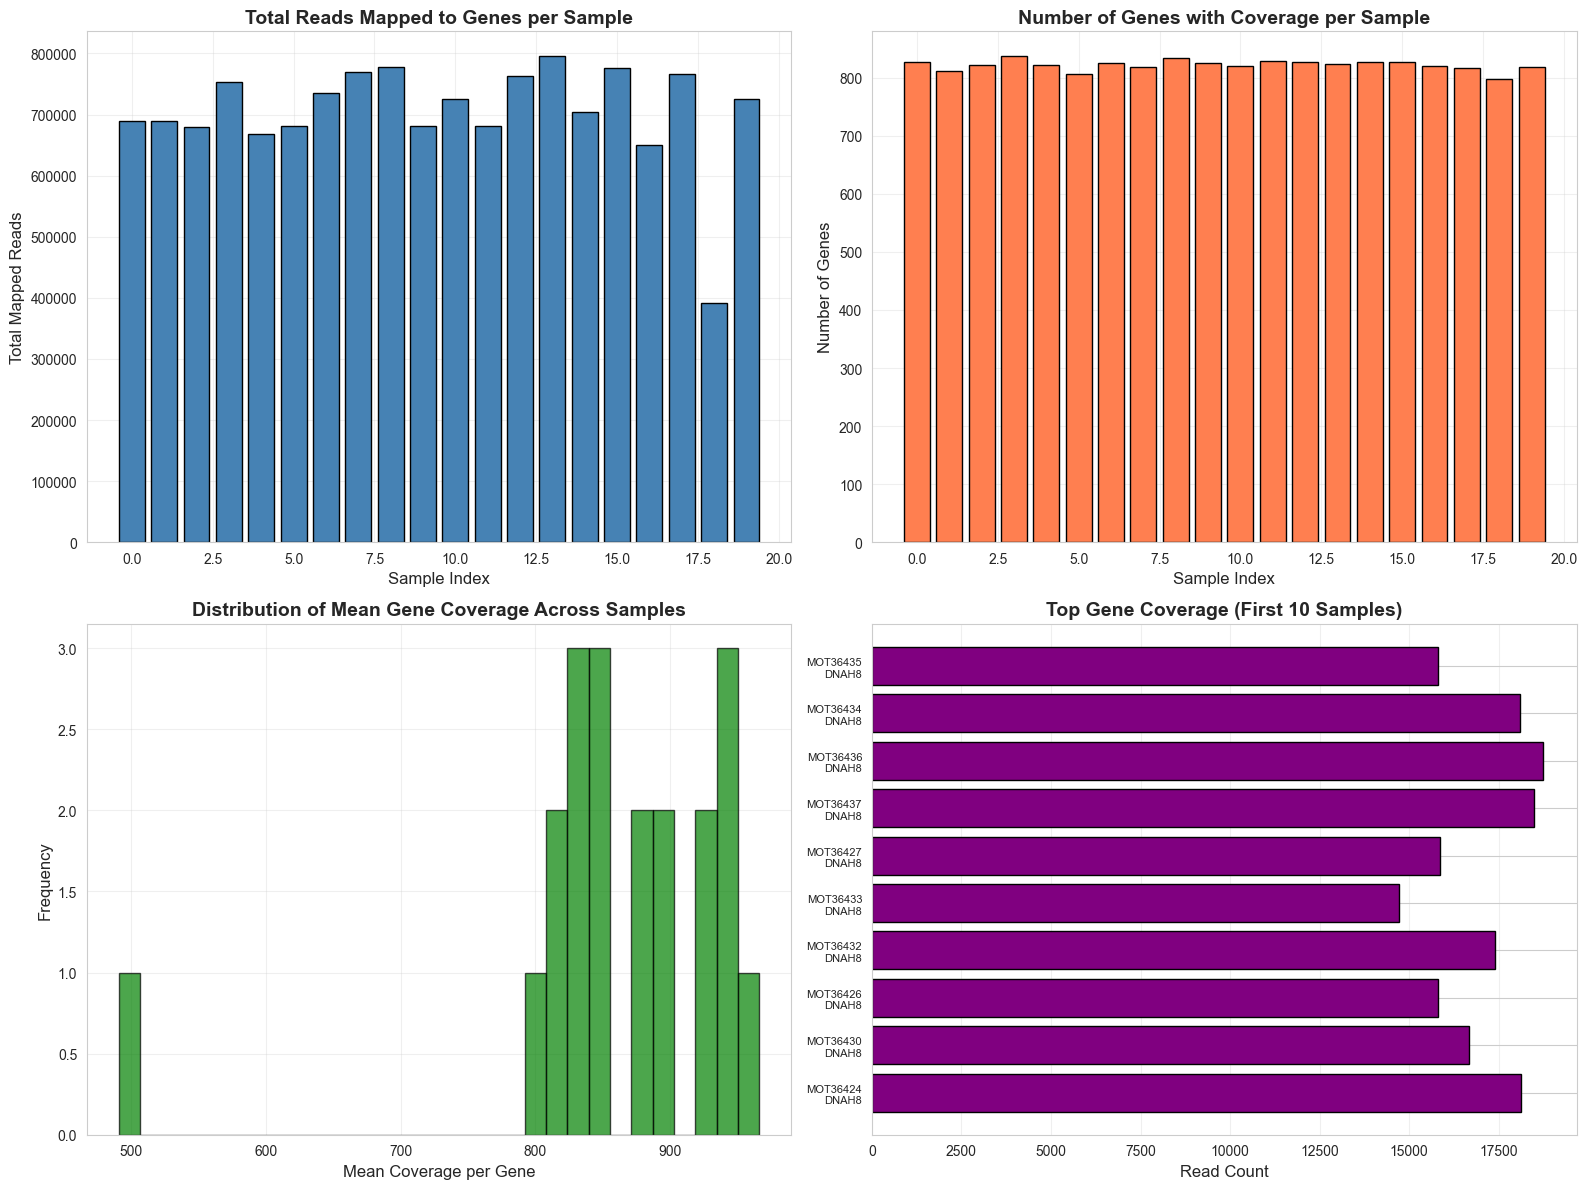


✓ Task 1 visualizations complete


In [11]:
# Visualization 1: Gene coverage distribution across samples
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Total reads per sample
axes[0, 0].bar(range(len(summary_df)), summary_df['Total_Reads'], color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Sample Index', fontsize=12)
axes[0, 0].set_ylabel('Total Mapped Reads', fontsize=12)
axes[0, 0].set_title('Total Reads Mapped to Genes per Sample', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Plot 2: Number of genes covered per sample
axes[0, 1].bar(range(len(summary_df)), summary_df['Total_Genes'], color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Sample Index', fontsize=12)
axes[0, 1].set_ylabel('Number of Genes', fontsize=12)
axes[0, 1].set_title('Number of Genes with Coverage per Sample', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Mean coverage distribution
axes[1, 0].hist(summary_df['Mean_Coverage'], bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Mean Coverage per Gene', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Distribution of Mean Gene Coverage Across Samples', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Plot 4: Top gene coverage comparison
top_samples = summary_df.head(10)
axes[1, 1].barh(range(len(top_samples)), top_samples['Top_Gene_Reads'], color='purple', edgecolor='black')
axes[1, 1].set_yticks(range(len(top_samples)))
axes[1, 1].set_yticklabels([f"{row['Sample']}\n{row['Top_Gene']}" for _, row in top_samples.iterrows()], fontsize=8)
axes[1, 1].set_xlabel('Read Count', fontsize=12)
axes[1, 1].set_title('Top Gene Coverage (First 10 Samples)', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/figures/task1_annotation_summary.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Task 1 visualizations complete")

---
# Task 2: Read Quality and Mapping Quality Analysis

**Objective:** Assess sequencing quality by analyzing mapping quality (MAPQ) scores across all samples.

**Scientific Rationale:** Mapping quality scores (MAPQ) indicate alignment confidence. Low MAPQ values suggest ambiguous mappings, which are particularly problematic in highly polymorphic regions like the MHC.

## 2.1 Extract Mapping Quality Statistics

In [12]:
def extract_mapping_quality(bam_file, sample_size=100000):
    """
    Extract mapping quality scores from BAM file.
    
    Parameters:
    -----------
    bam_file : str
        Path to BAM file
    sample_size : int
        Number of reads to sample for efficiency
    
    Returns:
    --------
    tuple : (mapq_values, read_stats)
    """
    bamfile = pysam.AlignmentFile(bam_file, 'rb')
    
    mapq_values = []
    total_reads = 0
    mapped_reads = 0
    properly_paired = 0
    
    for i, read in enumerate(bamfile.fetch("chr6", 28477797, 33448354)):
        if i >= sample_size:
            break
        
        total_reads += 1
        
        if not read.is_unmapped:
            mapped_reads += 1
            mapq_values.append(read.mapping_quality)
            
            if read.is_proper_pair:
                properly_paired += 1
    
    bamfile.close()
    
    read_stats = {
        'total_reads': total_reads,
        'mapped_reads': mapped_reads,
        'properly_paired': properly_paired,
        'mapping_rate': (mapped_reads / total_reads * 100) if total_reads > 0 else 0,
        'proper_pair_rate': (properly_paired / total_reads * 100) if total_reads > 0 else 0,
        'mean_mapq': np.mean(mapq_values) if mapq_values else 0,
        'median_mapq': np.median(mapq_values) if mapq_values else 0,
        'std_mapq': np.std(mapq_values) if mapq_values else 0
    }
    
    return mapq_values, read_stats

# Extract quality metrics for all samples
print("=" * 60)
print("TASK 2: QUALITY ASSESSMENT")
print("=" * 60)
FASTA_REF = "hla_gen.fasta"
quality_data = {}
stats_summary = []

for bam_file in bam_files:
    sample_name = os.path.basename(bam_file).replace('.bam', '')
    print(f"Analyzing {sample_name}...")
    
    mapq_values, read_stats = extract_mapping_quality(bam_file)
    quality_data[sample_name] = {
        'mapq': mapq_values,
        'stats': read_stats
    }
    
    stats_summary.append({
        'Sample': sample_name,
        **read_stats
    })

# Create summary statistics table
stats_df = pd.DataFrame(stats_summary)
stats_df.to_csv(f"{OUTPUT_DIR}/task2_quality/quality_summary.csv", index=False)
print("\n✓ Quality extraction complete")
print("\nQuality Statistics Summary (First 10 samples):")
print(stats_df.head(10).to_string(index=False))

TASK 2: QUALITY ASSESSMENT
Analyzing MOT36424...
Analyzing MOT36430...
Analyzing MOT36426...
Analyzing MOT36432...
Analyzing MOT36433...
Analyzing MOT36427...
Analyzing MOT36437...
Analyzing MOT36436...
Analyzing MOT36434...
Analyzing MOT36435...
Analyzing MOT36446...
Analyzing MOT36447...
Analyzing MOT36440...
Analyzing MOT36441...
Analyzing MOT36443...
Analyzing MOT36442...
Analyzing MOT36449...
Analyzing MOT36438...
Analyzing MOT36439...
Analyzing MOT36428...

✓ Quality extraction complete

Quality Statistics Summary (First 10 samples):
  Sample  total_reads  mapped_reads  properly_paired  mapping_rate  proper_pair_rate  mean_mapq  median_mapq  std_mapq
MOT36424        88748         88728            81684     99.977464         92.040384   2.533744          0.0 10.461377
MOT36430        87460         87440            79106     99.977132         90.448205   0.765714          0.0  5.413571
MOT36426        88791         88767            81178     99.972970         91.425933   1.116023  

## 2.2 Comprehensive Mapping Quality Visualizations

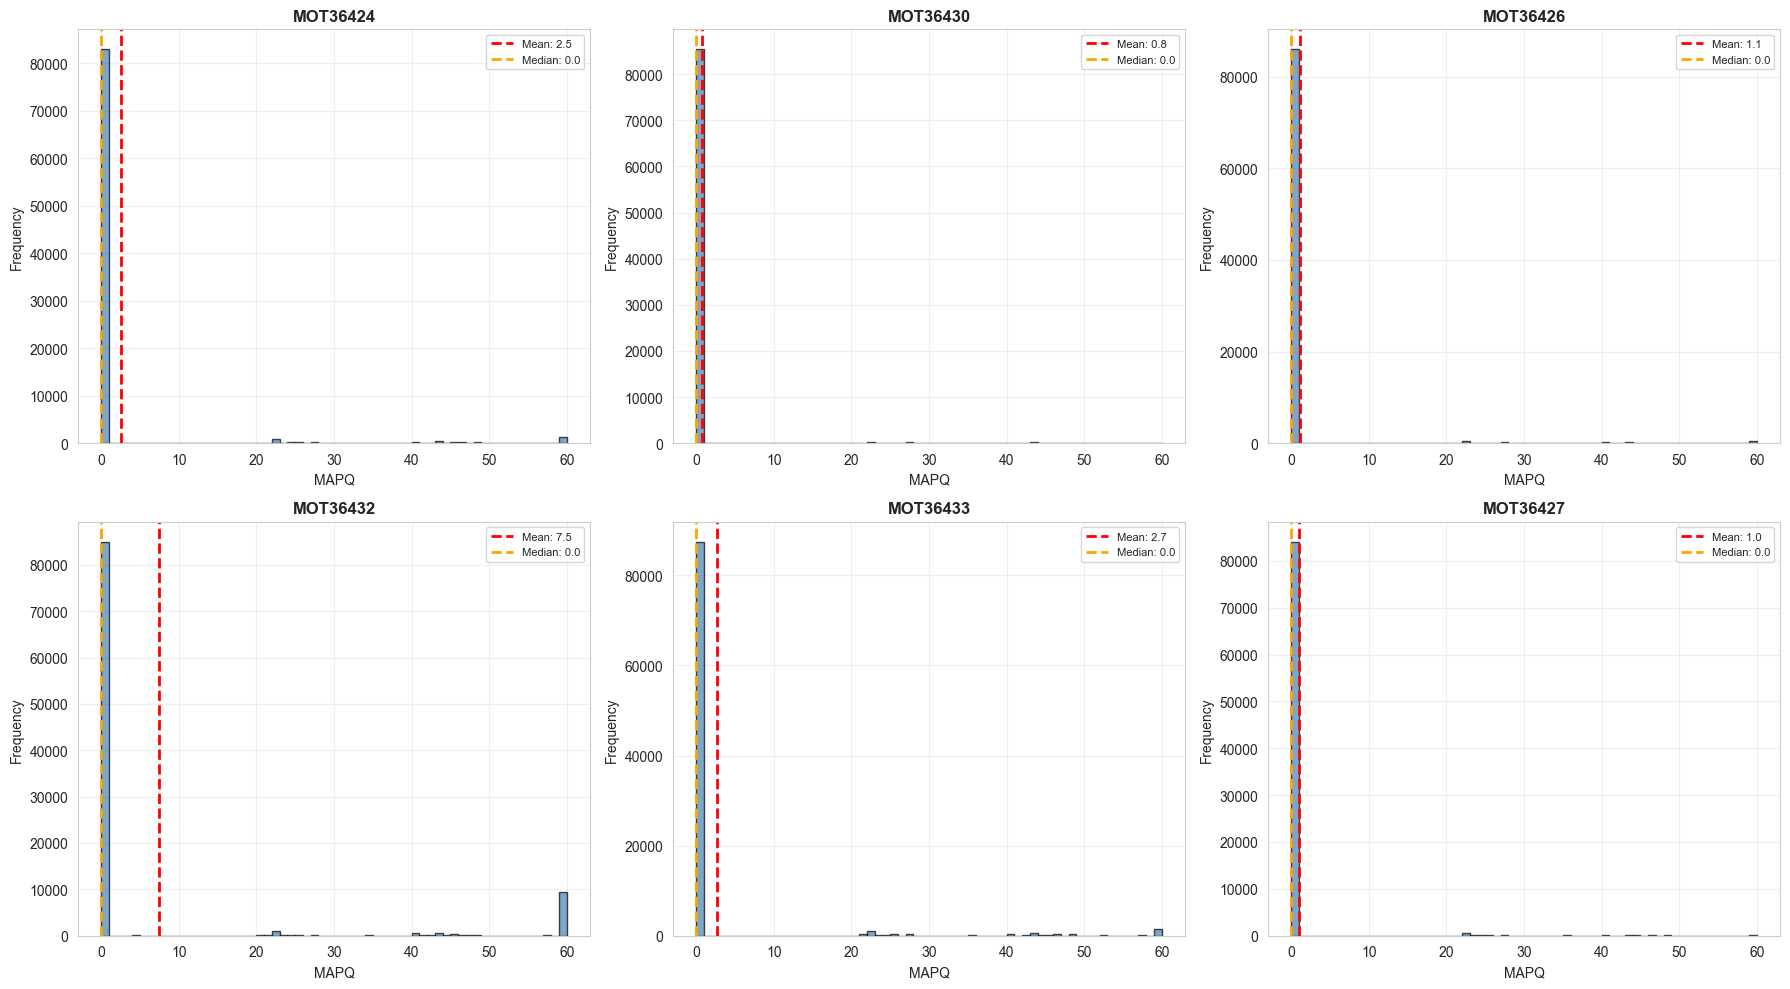

In [13]:
# Visualization 2.1: Individual sample MAPQ distributions (first 6 samples)
samples_to_plot = list(quality_data.keys())[:6]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, sample_name in enumerate(samples_to_plot):
    data = quality_data[sample_name]
    
    # Histogram
    axes[idx].hist(data['mapq'], bins=60, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].axvline(data['stats']['mean_mapq'], color='red', linestyle='--', 
                   linewidth=2, label=f"Mean: {data['stats']['mean_mapq']:.1f}")
    axes[idx].axvline(data['stats']['median_mapq'], color='orange', linestyle='--', 
                   linewidth=2, label=f"Median: {data['stats']['median_mapq']:.1f}")
    axes[idx].set_xlabel('MAPQ', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].set_title(f'{sample_name}', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_quality/individual_mapq_distributions.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

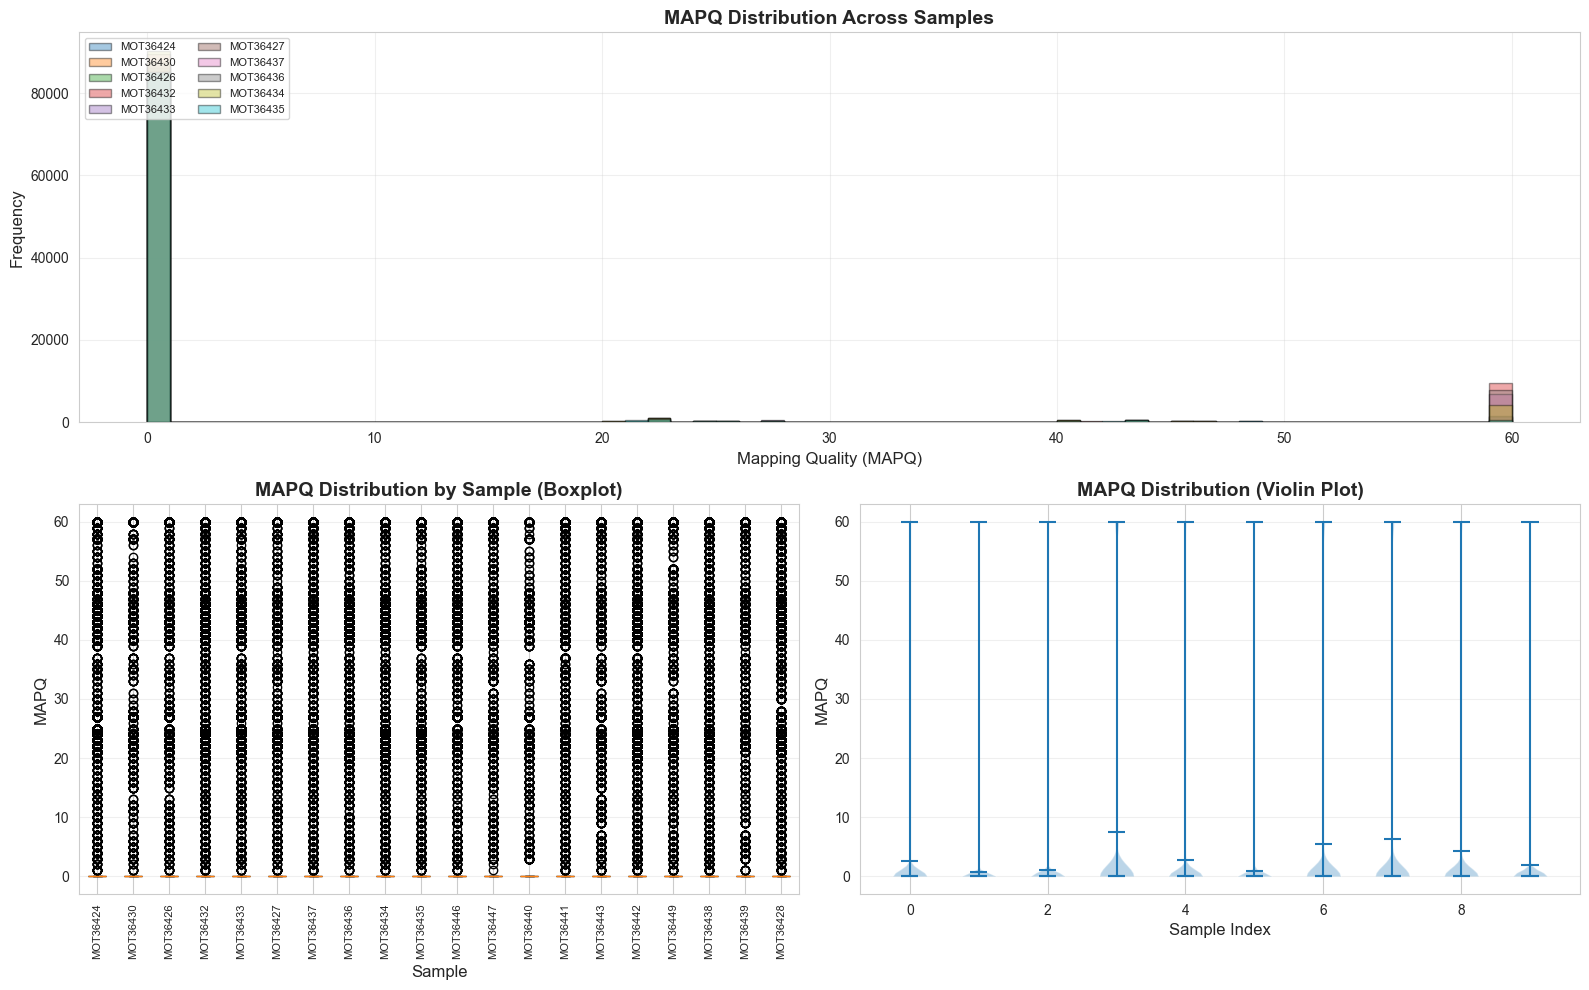

✓ Comparative MAPQ visualizations complete


In [14]:
# Visualization 2.2: Comparative MAPQ across all samples
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, figure=fig)

# Plot 1: Overlaid histograms (first 10 samples)
ax1 = fig.add_subplot(gs[0, :])
for i, (sample_name, data) in enumerate(list(quality_data.items())[:10]):
    ax1.hist(data['mapq'], bins=60, alpha=0.4, label=sample_name, edgecolor='black')
ax1.set_xlabel('Mapping Quality (MAPQ)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('MAPQ Distribution Across Samples', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=8, ncol=2)
ax1.grid(alpha=0.3)

# Plot 2: Box plot of MAPQ across samples
ax2 = fig.add_subplot(gs[1, 0])
mapq_data_list = [data['mapq'] for data in list(quality_data.values())[:20]]
sample_labels = [s for s in list(quality_data.keys())[:20]]
bp = ax2.boxplot(mapq_data_list, labels=sample_labels, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
ax2.set_xlabel('Sample', fontsize=12)
ax2.set_ylabel('MAPQ', fontsize=12)
ax2.set_title('MAPQ Distribution by Sample (Boxplot)', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=90, labelsize=8)
ax2.grid(alpha=0.3, axis='y')

# Plot 3: Violin plot
ax3 = fig.add_subplot(gs[1, 1])
parts = ax3.violinplot(mapq_data_list[:10], positions=range(10), showmeans=True, showmedians=True)
ax3.set_xlabel('Sample Index', fontsize=12)
ax3.set_ylabel('MAPQ', fontsize=12)
ax3.set_title('MAPQ Distribution (Violin Plot)', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_quality/comparative_mapq_analysis.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✓ Comparative MAPQ visualizations complete")

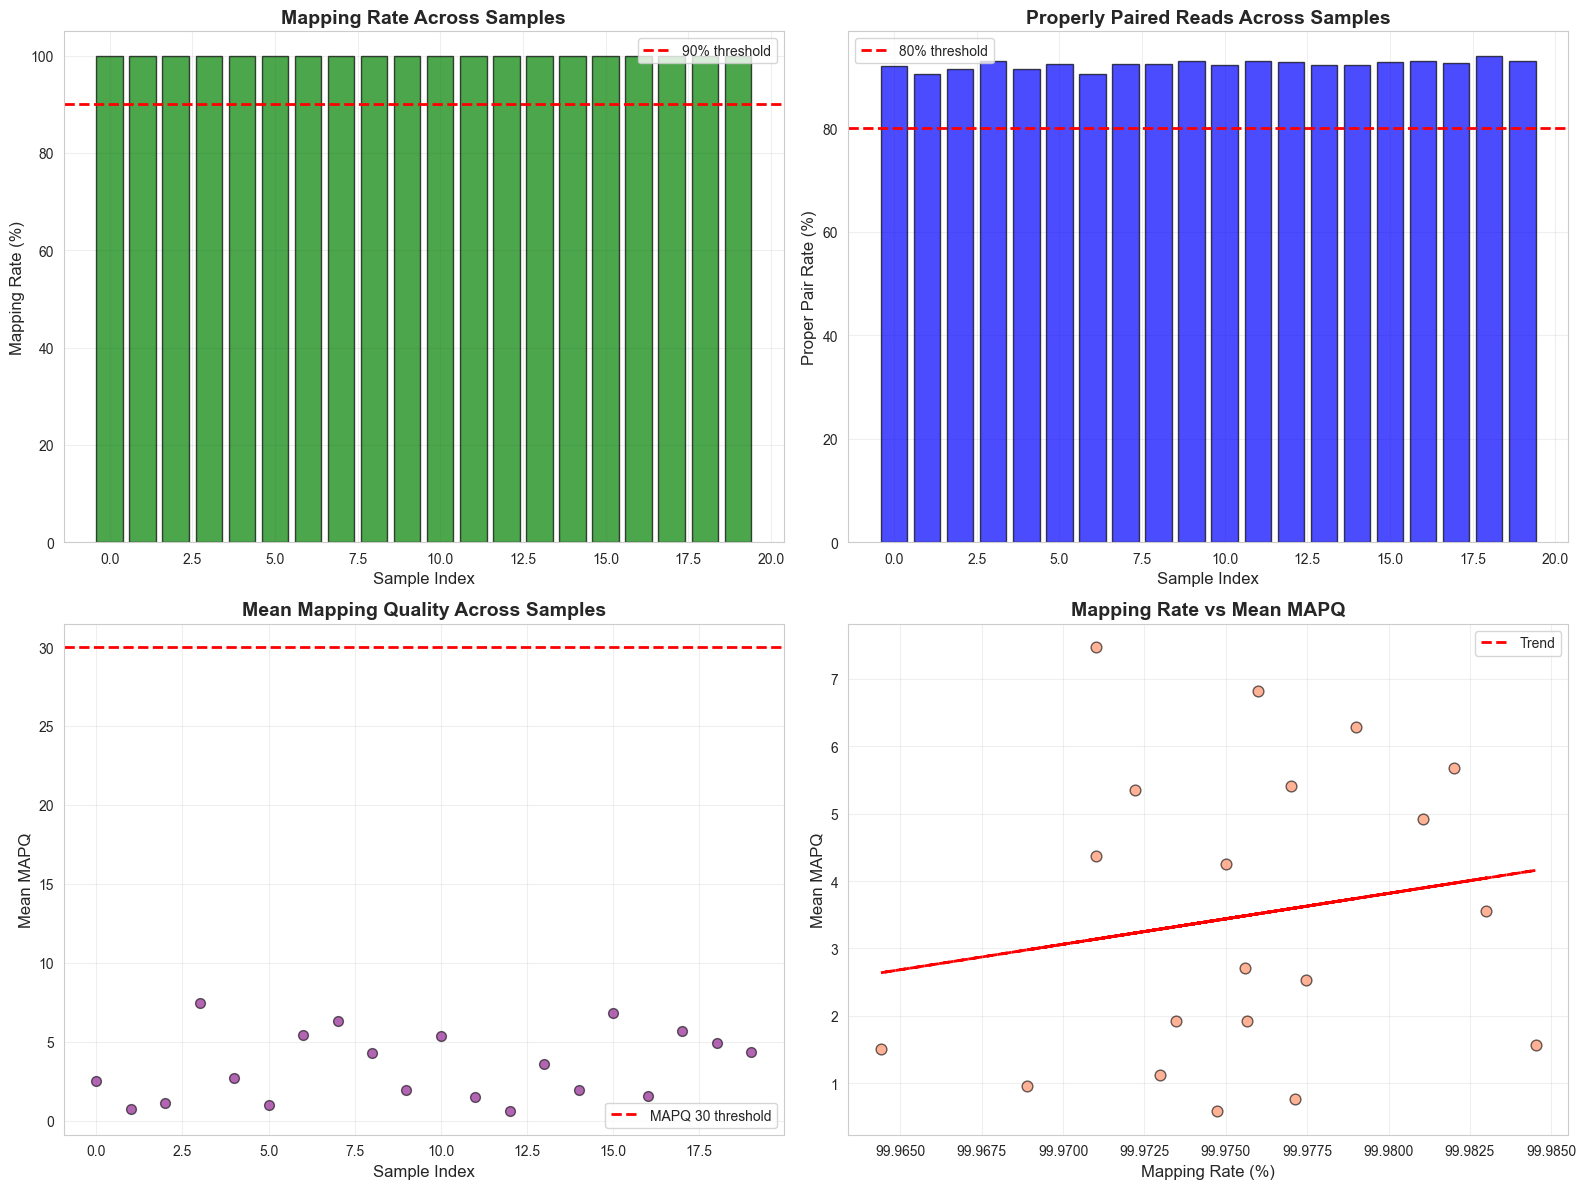

✓ Quality metrics visualizations complete


In [17]:
# Visualization 2.3: Quality metrics summary
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Mapping rate
axes[0, 0].bar(range(len(stats_df)), stats_df['mapping_rate'], color='green', edgecolor='black', alpha=0.7)
axes[0, 0].axhline(y=90, color='red', linestyle='--', linewidth=2, label='90% threshold')
axes[0, 0].set_xlabel('Sample Index', fontsize=12)
axes[0, 0].set_ylabel('Mapping Rate (%)', fontsize=12)
axes[0, 0].set_title('Mapping Rate Across Samples', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Proper pair rate
axes[0, 1].bar(range(len(stats_df)), stats_df['proper_pair_rate'], color='blue', edgecolor='black', alpha=0.7)
axes[0, 1].axhline(y=80, color='red', linestyle='--', linewidth=2, label='80% threshold')
axes[0, 1].set_xlabel('Sample Index', fontsize=12)
axes[0, 1].set_ylabel('Proper Pair Rate (%)', fontsize=12)
axes[0, 1].set_title('Properly Paired Reads Across Samples', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Mean MAPQ
axes[1, 0].scatter(range(len(stats_df)), stats_df['mean_mapq'], c='purple', s=50, alpha=0.6, edgecolor='black')
axes[1, 0].axhline(y=30, color='red', linestyle='--', linewidth=2, label='MAPQ 30 threshold')
axes[1, 0].set_xlabel('Sample Index', fontsize=12)
axes[1, 0].set_ylabel('Mean MAPQ', fontsize=12)
axes[1, 0].set_title('Mean Mapping Quality Across Samples', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Correlation between mapping rate and mean MAPQ
axes[1, 1].scatter(stats_df['mapping_rate'], stats_df['mean_mapq'], c='coral', s=60, alpha=0.6, edgecolor='black')
# Add regression line
z = np.polyfit(stats_df['mapping_rate'], stats_df['mean_mapq'], 1)
p = np.poly1d(z)
axes[1, 1].plot(stats_df['mapping_rate'], p(stats_df['mapping_rate']), "r--", linewidth=2, label='Trend')
axes[1, 1].set_xlabel('Mapping Rate (%)', fontsize=12)
axes[1, 1].set_ylabel('Mean MAPQ', fontsize=12)
axes[1, 1].set_title('Mapping Rate vs Mean MAPQ', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/task2_quality/quality_metrics_summary.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✓ Quality metrics visualizations complete")

## 2.3 Quality Assessment Interpretation

In [15]:
# Quality assessment interpretation
print("\n" + "=" * 60)
print("QUALITY ASSESSMENT INTERPRETATION")
print("=" * 60)

problematic_samples = []

for sample_name, data in quality_data.items():
    stats = data['stats']
    
    # Quality flags
    issues = []
    if stats['mapping_rate'] < 90:
        issues.append("LOW_MAPPING_RATE")
    if stats['proper_pair_rate'] < 80:
        issues.append("LOW_PROPER_PAIR_RATE")
    if stats['mean_mapq'] < 30:
        issues.append("LOW_MEAN_MAPQ")
    
    if issues:
        problematic_samples.append({
            'Sample': sample_name,
            'Issues': ', '.join(issues),
            'Mapping_Rate': f"{stats['mapping_rate']:.2f}%",
            'Proper_Pair_Rate': f"{stats['proper_pair_rate']:.2f}%",
            'Mean_MAPQ': f"{stats['mean_mapq']:.2f}"
        })

if problematic_samples:
    prob_df = pd.DataFrame(problematic_samples)
    print(f"\n⚠️  Found {len(problematic_samples)} samples with quality issues:\n")
    print(prob_df.to_string(index=False))
    prob_df.to_csv(f"{OUTPUT_DIR}/task2_quality/problematic_samples.csv", index=False)
else:
    print("\n✓ All samples passed quality thresholds")

# Statistical summary
print("\n\nOverall Quality Statistics:")
print("=" * 60)
print(f"Mean mapping rate: {stats_df['mapping_rate'].mean():.2f}% ± {stats_df['mapping_rate'].std():.2f}%")
print(f"Mean proper pair rate: {stats_df['proper_pair_rate'].mean():.2f}% ± {stats_df['proper_pair_rate'].std():.2f}%")
print(f"Mean MAPQ: {stats_df['mean_mapq'].mean():.2f} ± {stats_df['mean_mapq'].std():.2f}")
print(f"\nSamples passing all QC thresholds: {len(quality_data) - len(problematic_samples)}/{len(quality_data)}")

print("\n✓ Task 2 Complete: Quality assessment finished")


QUALITY ASSESSMENT INTERPRETATION

⚠️  Found 20 samples with quality issues:

  Sample        Issues Mapping_Rate Proper_Pair_Rate Mean_MAPQ
MOT36424 LOW_MEAN_MAPQ       99.98%           92.04%      2.53
MOT36430 LOW_MEAN_MAPQ       99.98%           90.45%      0.77
MOT36426 LOW_MEAN_MAPQ       99.97%           91.43%      1.12
MOT36432 LOW_MEAN_MAPQ       99.97%           92.92%      7.47
MOT36433 LOW_MEAN_MAPQ       99.98%           91.37%      2.71
MOT36427 LOW_MEAN_MAPQ       99.97%           92.37%      0.96
MOT36437 LOW_MEAN_MAPQ       99.98%           90.36%      5.41
MOT36436 LOW_MEAN_MAPQ       99.98%           92.39%      6.29
MOT36434 LOW_MEAN_MAPQ       99.98%           92.29%      4.25
MOT36435 LOW_MEAN_MAPQ       99.98%           92.94%      1.92
MOT36446 LOW_MEAN_MAPQ       99.97%           92.19%      5.34
MOT36447 LOW_MEAN_MAPQ       99.96%           93.00%      1.51
MOT36440 LOW_MEAN_MAPQ       99.97%           92.73%      0.58
MOT36441 LOW_MEAN_MAPQ       99.98%    

---
# Task 3: MHC Gene Extraction and HLA Allele Typing

**Objective:** Extract MHC-specific genes and perform allele typing through pairwise sequence alignment.

**Scientific Rationale:** HLA allele identification is crucial for understanding immune system diversity. Different HLA alleles are associated with varying disease susceptibilities and transplant compatibility.

## 3.1 Extract MHC Genes from Annotations

In [16]:
def extract_mhc_genes(annotation_df, mhc_genes):
    """
    Filter annotation dataframe for MHC genes only.
    
    Parameters:
    -----------
    annotation_df : DataFrame
        Full gene annotation dataframe
    mhc_genes : list
        List of MHC gene names
    
    Returns:
    --------
    DataFrame : Filtered MHC genes with classification
    """
    mhc_df = annotation_df[annotation_df['gene_name'].isin(mhc_genes)].copy()
    
    # Classify MHC genes
    def classify_mhc(gene_name):
        if gene_name in MHC_CLASS_I:
            return 'Class I'
        elif gene_name in MHC_CLASS_II:
            return 'Class II'
        elif gene_name in MHC_CLASS_III:
            return 'Class III'
        return 'Unknown'
    
    mhc_df['mhc_class'] = mhc_df['gene_name'].apply(classify_mhc)
    
    return mhc_df

# Extract MHC genes for all samples
print("=" * 60)
print("TASK 3: MHC GENE ANALYSIS AND ALLELE TYPING")
print("=" * 60)

mhc_results = {}
for sample_name, annotation_df in annotation_results.items():
    mhc_df = extract_mhc_genes(annotation_df, MHC_GENES)
    mhc_results[sample_name] = mhc_df
    
    # Save MHC-specific table
    mhc_df.to_csv(f"{OUTPUT_DIR}/task3_mhc_typing/{sample_name}_mhc_genes.csv", index=False)

# Summary statistics
mhc_summary = []
for sample_name, mhc_df in mhc_results.items():
    mhc_summary.append({
        'Sample': sample_name,
        'Total_MHC': len(mhc_df),
        'Class_I': len(mhc_df[mhc_df['mhc_class'] == 'Class I']),
        'Class_II': len(mhc_df[mhc_df['mhc_class'] == 'Class II']),
        'Class_III': len(mhc_df[mhc_df['mhc_class'] == 'Class III']),
        'Total_MHC_Reads': mhc_df['read_count'].sum()
    })

mhc_summary_df = pd.DataFrame(mhc_summary)
print("\nMHC Gene Detection Summary (First 10 samples):")
print(mhc_summary_df.head(10).to_string(index=False))
mhc_summary_df.to_csv(f"{OUTPUT_DIR}/task3_mhc_typing/mhc_summary.csv", index=False)

print("\n✓ MHC gene extraction complete")

TASK 3: MHC GENE ANALYSIS AND ALLELE TYPING

MHC Gene Detection Summary (First 10 samples):
  Sample  Total_MHC  Class_I  Class_II  Class_III  Total_MHC_Reads
MOT36424         28        6        11         11            12982
MOT36430         28        6        11         11            11344
MOT36426         28        6        11         11            12195
MOT36432         28        6        11         11            22122
MOT36433         28        6        11         11            13554
MOT36427         27        6        10         11            11615
MOT36437         28        6        11         11            19811
MOT36436         28        6        11         11            19701
MOT36434         28        6        11         11            16886
MOT36435         28        6        11         11            11801

✓ MHC gene extraction complete


## 3.2 MHC Coverage Visualizations

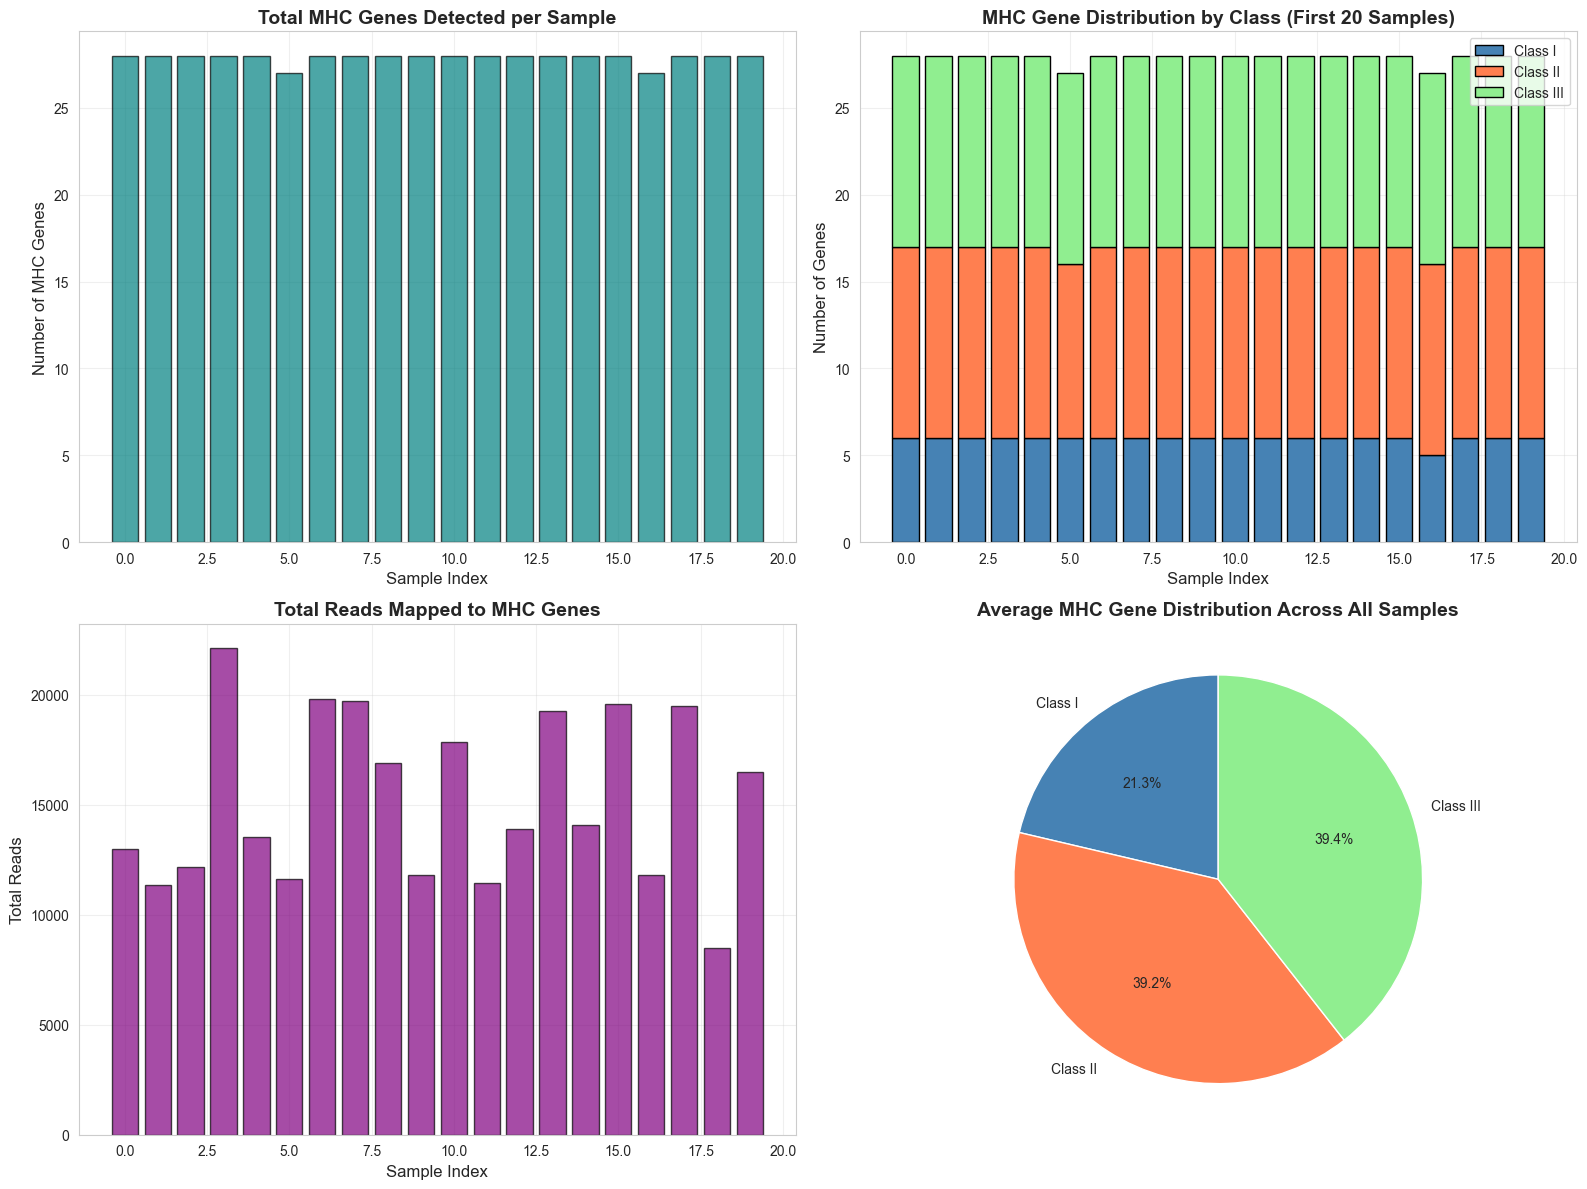

✓ MHC coverage visualizations complete


In [17]:
# Visualization 3.1: MHC gene coverage by class
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Total MHC genes detected per sample
axes[0, 0].bar(range(len(mhc_summary_df)), mhc_summary_df['Total_MHC'], color='teal', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Sample Index', fontsize=12)
axes[0, 0].set_ylabel('Number of MHC Genes', fontsize=12)
axes[0, 0].set_title('Total MHC Genes Detected per Sample', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Plot 2: Stacked bar chart - MHC class distribution
x = range(min(20, len(mhc_summary_df)))
axes[0, 1].bar(x, mhc_summary_df['Class_I'][:20], label='Class I', color='steelblue', edgecolor='black')
axes[0, 1].bar(x, mhc_summary_df['Class_II'][:20], bottom=mhc_summary_df['Class_I'][:20], 
               label='Class II', color='coral', edgecolor='black')
axes[0, 1].bar(x, mhc_summary_df['Class_III'][:20], 
               bottom=mhc_summary_df['Class_I'][:20] + mhc_summary_df['Class_II'][:20],
               label='Class III', color='lightgreen', edgecolor='black')
axes[0, 1].set_xlabel('Sample Index', fontsize=12)
axes[0, 1].set_ylabel('Number of Genes', fontsize=12)
axes[0, 1].set_title('MHC Gene Distribution by Class (First 20 Samples)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Total reads in MHC region
axes[1, 0].bar(range(len(mhc_summary_df)), mhc_summary_df['Total_MHC_Reads'], color='purple', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Sample Index', fontsize=12)
axes[1, 0].set_ylabel('Total Reads', fontsize=12)
axes[1, 0].set_title('Total Reads Mapped to MHC Genes', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Plot 4: Pie chart - Average MHC class distribution
avg_class_distribution = [
    mhc_summary_df['Class_I'].sum(),
    mhc_summary_df['Class_II'].sum(),
    mhc_summary_df['Class_III'].sum()
]
labels = ['Class I', 'Class II', 'Class III']
colors = ['steelblue', 'coral', 'lightgreen']
axes[1, 1].pie(avg_class_distribution, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Average MHC Gene Distribution Across All Samples', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/figures/mhc_coverage_summary.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✓ MHC coverage visualizations complete")

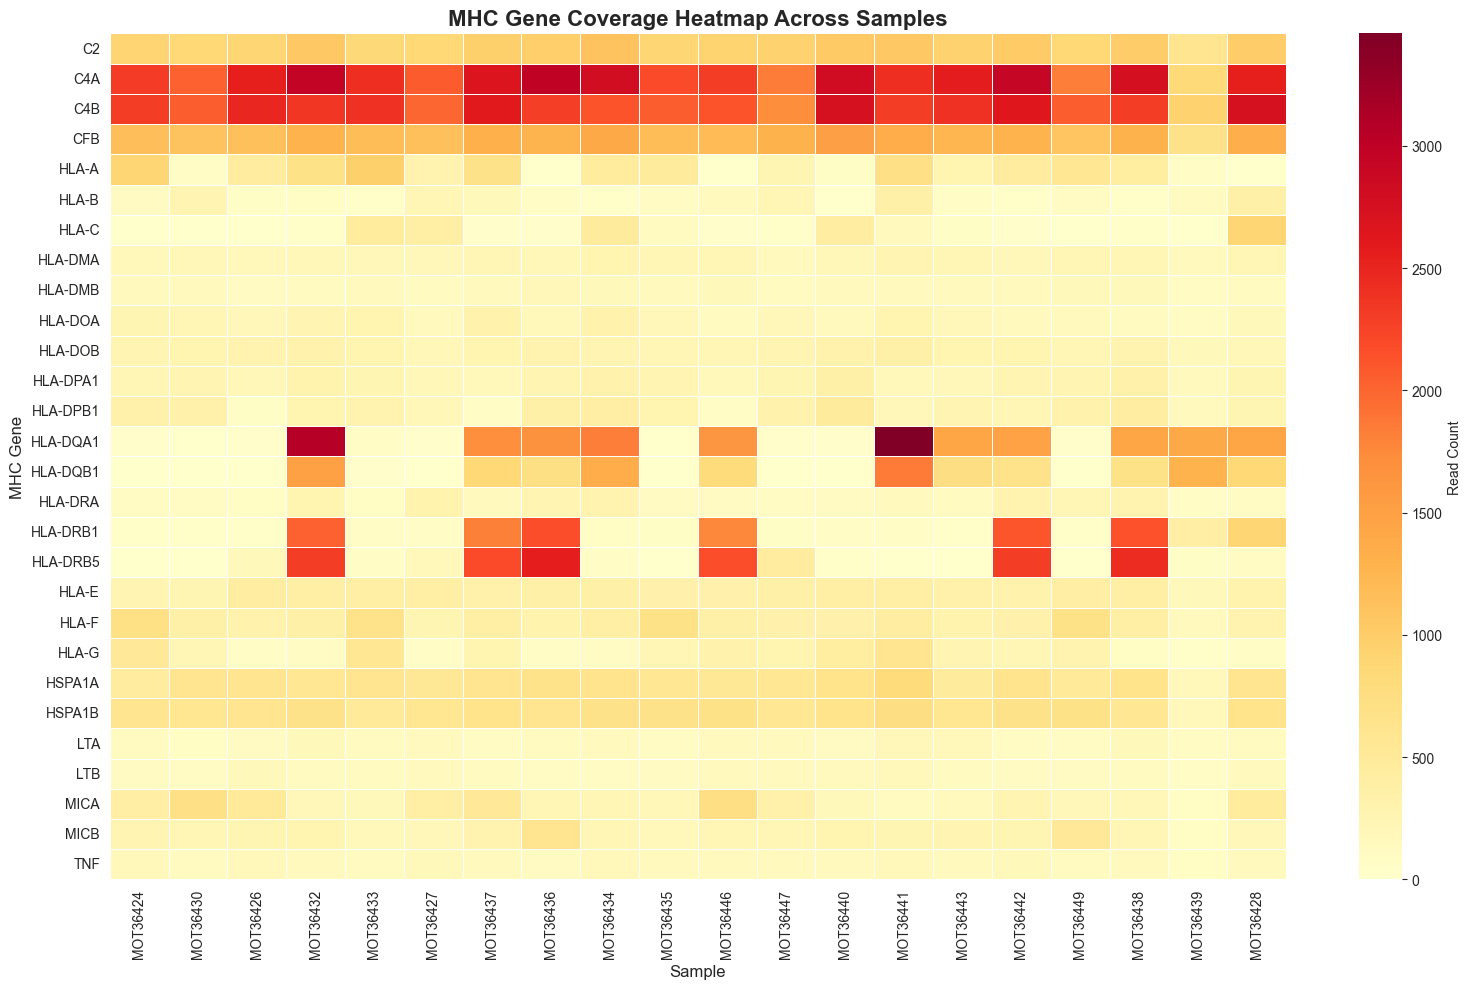

✓ MHC heatmap visualization complete


In [22]:
# Visualization 3.2: Heatmap of MHC gene coverage across samples
# Prepare data for heatmap
heatmap_data = []
all_mhc_genes = set()

for sample_name, mhc_df in list(mhc_results.items())[:20]:  # First 20 samples
    for gene in mhc_df['gene_name']:
        all_mhc_genes.add(gene)

# Create matrix
coverage_matrix = pd.DataFrame(0, 
                               index=sorted(all_mhc_genes), 
                               columns=list(mhc_results.keys())[:20])

for sample_name, mhc_df in list(mhc_results.items())[:20]:
    for _, row in mhc_df.iterrows():
        coverage_matrix.loc[row['gene_name'], sample_name] = row['read_count']

# Plot heatmap
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(coverage_matrix, cmap='YlOrRd', annot=False, fmt='d', 
            cbar_kws={'label': 'Read Count'}, linewidths=0.5)
ax.set_title('MHC Gene Coverage Heatmap Across Samples', fontsize=16, fontweight='bold')
ax.set_xlabel('Sample', fontsize=12)
ax.set_ylabel('MHC Gene', fontsize=12)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/figures/mhc_coverage_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✓ MHC heatmap visualization complete")

## 3.3 Extract MHC Gene Sequences

In [ ]:
from collections import Counter
import pysam
import os

def normalize_chrom(chrom, bam_refs):
    """
    Standardizes chromosome names to match the BAM file.
    """
    if chrom in bam_refs: return chrom
    # Try removing 'chr'
    if chrom.startswith("chr"):
        c = chrom[3:]
        if c in bam_refs: return c
    # Try adding 'chr'
    if not chrom.startswith("chr"):
        c = "chr" + chrom
        if c in bam_refs: return c
    return chrom

def extract_sequences_from_bam(bam_file, gene_info, fasta_ref=None):
    """
    Extracts consensus sequence DIRECTLY from BAM reads (Reference-Free).
    """
    try:
        bamfile = pysam.AlignmentFile(bam_file, 'rb')
        bam_refs = set(bamfile.references)
        
        # 1. Normalize Chromosome Name
        target_chrom = normalize_chrom(gene_info['chromosome'], bam_refs)
        if target_chrom not in bam_refs:
            return None

        start = gene_info['start'] - 1
        end = gene_info['end']
        
        # 2. Build Sequence from Scratch (Pileup)
        # Initialize with 'N' (unknown) for the whole gene length
        gene_len = end - start
        consensus = ['N'] * gene_len
        
        # Iterate over columns in the BAM file
        for pileupcolumn in bamfile.pileup(target_chrom, start, end, truncate=True):
            bases = []
            for pileupread in pileupcolumn.pileups:
                if not pileupread.is_del and not pileupread.is_refskip:
                    if pileupread.query_position is not None:
                        bases.append(pileupread.alignment.query_sequence[pileupread.query_position])
            
            # Pick most frequent base
            if bases:
                best_base = Counter(bases).most_common(1)[0][0]
                pos_in_gene = pileupcolumn.pos - start
                if 0 <= pos_in_gene < gene_len:
                    consensus[pos_in_gene] = best_base
        
        bamfile.close()
        
        # 3. Validation: Return sequence only if it has SOME data
        seq_str = "".join(consensus)
        non_n_count = len(seq_str) - seq_str.count('N')
        
        # If less than 100 bases are known, it's too poor to type
        if non_n_count < 100:
            return None 
            
        return seq_str
    
    except Exception as e:
        print(f"Error extracting {gene_info.get('gene_name', 'gene')}: {e}")
        return None
import os
import glob

print("--- RE-RUNNING SEQUENCE EXTRACTION (DYNAMIC LOOP FIX) ---")

# 1. Reset the storage dictionary
mhc_sequences = {} 

# 2. Get the list of BAM files
bam_files = glob.glob("bam_files/*.bam")
print(f"Found {len(bam_files)} BAM files to process.")

# 3. Iterate through EACH file
for bam_path in bam_files:
    # Extract sample name from filename (e.g., 'bam_files/MOT36424.bam' -> 'MOT36424')
    sample_name = os.path.basename(bam_path).replace('.bam', '')
    
    print(f"Processing {sample_name}...", end=" ")
    
    # Storage for this specific sample
    sample_genes = {}
    
    # 4. Get the gene coordinates for THIS sample
    if sample_name in annotation_results:
        # Filter for the MHC genes we care about
        genes_to_extract = annotation_results[sample_name]
        target_genes = genes_to_extract[genes_to_extract['gene_name'].isin(MHC_GENES)]
        
        # 5. Extract sequence for each target gene
        for _, row in target_genes.iterrows():
            gene_name = row['gene_name']
            
            # --- Pass 'bam_path' (the current file), NOT a hardcoded string ---
            seq = extract_sequences_from_bam(bam_path, row)
            
            if seq:
                sample_genes[gene_name] = seq
        
        print(f"-> Extracted {len(sample_genes)} genes.")
        mhc_sequences[sample_name] = sample_genes
        
    else:
        print("-> ⚠ Skipped (No annotation data found).")

print(f"\n✓ Extraction complete. 'mhc_sequences' now contains unique DNA for {len(mhc_sequences)} samples.")

--- RE-RUNNING SEQUENCE EXTRACTION (DYNAMIC LOOP FIX) ---
Found 20 BAM files to process.
Processing MOT36424... -> Extracted 26 genes.
Processing MOT36430... -> Extracted 23 genes.
Processing MOT36426... -> Extracted 25 genes.
Processing MOT36432... -> Extracted 28 genes.
Processing MOT36433... -> Extracted 28 genes.
Processing MOT36427... -> Extracted 26 genes.
Processing MOT36437... -> Extracted 28 genes.
Processing MOT36436... -> Extracted 27 genes.
Processing MOT36434... -> Extracted 28 genes.
Processing MOT36435... -> Extracted 25 genes.
Processing MOT36446... -> Extracted 28 genes.
Processing MOT36447... -> Extracted 26 genes.
Processing MOT36440... -> Extracted 28 genes.
Processing MOT36441... -> Extracted 28 genes.
Processing MOT36443... -> Extracted 27 genes.
Processing MOT36442... -> Extracted 28 genes.
Processing MOT36449... -> Extracted 25 genes.
Processing MOT36438... -> Extracted 28 genes.
Processing MOT36439... -> Extracted 28 genes.
Processing MOT36428... -> Extracted 2

## 1.4 Summary Statistics and Visualizations for Task 1

## 3.4 HLA Reference Database Setup

In [19]:
# Create mock HLA reference database (in practice, use IMGT/HLA database)
def create_mock_hla_reference():
    """
    Create mock HLA reference alleles for demonstration.
    
    In production, download from IMGT/HLA database:
    https://www.ebi.ac.uk/ipd/imgt/hla/
    
    This function creates representative allele sequences for the most common
    HLA alleles in human populations.
    """
    reference_alleles = {
        'HLA-A': {
            'A*01:01': 'ATGGCCGTCATGGCGCCCCGAACCCTCCTCCTGCTACTCTCGGGGGCCCTGGCCCTGACCCAGACCTGGGCGGGTGAGTGCGGGGTCGGGAGGGAAACCGCCTCTGCGGGGAGAAGCAAGGGGCCCTCCTGGCGGGGGCGCAGGACCGGGGGAGCCGCGCCGGGAGGAGGGTCGGGCAGGTCTCAGCCACTGCTCGCCCCCAGGCTCCCACTCCATGAGGTATTTCTTCACATCCGTGTCCCGGCCCGGCCGCGGGGAGCCCCGCTTCATCGCAGTGGGCTACGTGGACGACACCCAGTTCGTGAGGTTCGACAGCGACGCCGCGAGTCCGAGGATGGCCGTCATGGCGCCCCGAACCGGGACGGAGCTCCGCAGGTACCGCTATGACCAGGAAGGGATACATCGCCCTGAACGAGGATCTGCGCTCCTGGACCGCCGCGGACACGGCGGCTCAGATCACCCAGCGCAAGTGGGAGGCGGCCCATGTGGCGGAGCAGCTGAGAGCCTACCTGGAGGGCACGTGCGTGGAGTGGCTCCGCAGATACCTGGAGAACGGGAAGGAGACGCTGCAGCGCGCGG',
            'A*02:01': 'ATGGCCGTCATGGCGCCCCGAACCCTGATCCTGCTACTCTCGGGGGCCCTGGCCCTGACCCAGACCTGGGCGGGTGAGTGCGGGGTCGGGAGGGAAACCGCCTCTGCGGGGAGAAGCAAGGGGCCCTCCTGGCGGGGGCGCAGGACCGGGGGAGCCGCGCCGGGAGGAGGGTCGGGCAGGTCTCAGCCACTGCTCGCCCCCAGGCTCCCACTCCATGAGGTATTTCTCCACATCCGTGTCCCGGCCCGGCCGCGGGGAGCCCCACTTCATCGCAGTGGGCTACGTGGACGACACGCAGTTCGTGCGGTTCGACAGCGACGCCGCGAGCCAGAGGATGGAGCCGCGGGCGCCGTGGATAGAGCAGGAGGGGCCGGAGTATTGGGACGGGGAGACACGGAAAGTGAAGGCCCACTCACAGACTCACCGAGTGGACCTGGGGACCCTGCGCGGCTACTACAACCAGAGCGAGGCCG',
            'A*03:01': 'ATGGCCGTCATGGCGCCCCGAACCCTCATCCTGCTACTCTCGGGGGCCCTGGCCCTGACCCAGACCTGGGCGGGTGAGTGCGGGGTCGGGAGGGAAACCGCCTCTGCGGGGAGAAGCAAGGGGCCCTCCTGGCGGGGGCGCAGGACCGGGGGAGCCGCGCCGGGAGGAGGGTCGGGCAGGTCTCAGCCACTGCTCGCCCCCAGGCTCCCACTCCATGAGGTATTTCTTCACATCCGTGTCCCGGCCCGGCCGCGGGGAGCCCCGCTTCATCGCCGTGGGCTACGTGGACGACACGCAGTTCGTGCGGTTCGACAGCGACGCCGCGAGTCCGAGAATGGCGCCCCGCGGCGCCGTGGATAGAGCAGGAGGGGCCGGAGTATTGGGACGGGGAGACACAGAAGTACAAGCGCCAGGCACAGGCTGACCGAGTGAGCCTGCGGAACCTGCGCGGCTACTACAACCAGAGCGAGGCCGGGTCTCACACCCTCCAGAGGATGTACGGCTGCGACGTGGGGCCGGACGGGCGCCTCCTCCGCGGGTATGACCAGTCCGCCTACGACGGCGCGGATTACATCGCCCTGAACGAGGACCTGCGCTCCTGGACCGCCGCGGACACGGCGGCTCAGATCACCCAGCGCAAGTGGGAGGCGGTCCATGCGGCGGAGCAGCGGAGAGCCTACCTGGAGGGCCTGTGCGTGGAGTGGCTCCGCAGATACCTGGAGAACGGGAAGGAGACGCTGCAGCGCACGG',
            'A*24:02': 'ATGGCCGTCATGGCGCCCCGAACCCTCCTGCTGCTACTCTCGGGGGCCCTGGCCCTGACCCAGACCTGGGCGGGTGAGTGCGGGGTCGGGAGGGAAACCGCCTCTGCGGGGAGAAGCAAGGGGCCCTCCTGGCGGGGGCGCAGGACCGGGGGAGCCGCGCCGGGAGGAGGGTCGGGCAGGTCTCAGCCACTGCTCGCCCCCAGGCTCCCACTCCATGAGGTATTTCTACACCTCCGTGTCCCGGCCCGGCCGCGGGGAGCCCCGCTTCATCGCAGTGGGCTACGTGGACGACACCCAGTTCGTGAGGTTCGACAGCGACGCCGCGAGTCCAAGAGGGGAGCCGCGGGCGCCGTGGGTGGAGCAGGAGGGGCCGGAGTATTGGGACCGGGAGACACAGAAGTACAAGCGCCAGGCACAGGCTGACCGAGTGAGCCTGCGGAACCTGCGCGGCTACTACAACCAGAGCGAGGCCGGGTCTCACACCCTCCAGAGCATGTACGGCTGCGACGTGGGGCCGGACGGGCGCCTCCTCCGCGGGTATGACCAGTCCGCCTACGACGGCGCGGATTACATCGCCCTGAACGAGGACCTGCGCTCCTGGACCGCCGCGGACACGGCGGCTCAGATCACCCAGCGCAAGTGGGAGGCGGTCCATGCGGCGGAGCAGCGGAGAGCCTACCTGGAGGGCCTGTGCGTGGAGTGGCTCCGCAGATACCTGGAGAACGGGAAGGAGACGCTGCAGCGCACGG'
        },
        'HLA-B': {
            'B*07:02': 'ATGCGGGTCACGGCGCCCCGAACCCTCCTCCTGCTACTCTCGGGGGCCCTGGCCCTGACCCAGACCTGGGCGGGCTCCTCCAGGGTCTCAGGCCCCGAAGGCGGTGTATGGATTGGGGAGTCCCAGCCTTGGGGATTCCCCAACTCCGCAGTTTCTTTTCTCCCTCTCCCAACCTACGTATTTCTTCACATCCGTGTCCCGGCCCGGCCGCGGGGAGCCCCGCTTCATCGCAGTGGGCTACGTGGACGACACGCAGTTCGTGCGGTTCGACAGCGACGCCGCGAGCCAGAGGATGGAGCCGCGGGCGCCGTGGATAGAGCAGGAGGGGCCGGAGTATTGGGACCGGAACACGGAGCTCCGGATCACCAGGCTGCAGCGCGCGG',
            'B*08:01': 'ATGCGGGTCACGGCGCCCCGAACCGTCCTCCTGCTACTCTCGGGGGCCCTGGCCCTGACCCAGACCTGGGCGGGCTCCTCCAGGGTCTCAGGCCCCGAAGGCGGTGTATGGATTGGGGAGTCCCAGCCTTGGGGATTCCCCAACTCCGCAGTTTCTTTTCTCCCTCTCCCAACCTACGTATTTCTTCACATCCGTGTCCCGGCCCGGCCGCGGGGAGCCCCGCTTCATCGCAGTGGGCTACGTGGACGACACGCAGTTCGTGCGGTTCGACAGCGACGCCGCGAGCCAGAAGATGGAGCCGCGGGCGCCGTGGATAGAGCAGGAGGGGCCGGAGTATTGGGACCGGAACACGGAGCTCCGGATCACCAGGCTGCAGCGCGCGG',
            'B*44:02': 'ATGCGGGTCACGGCGCCCCGAACCCTCATCCTGCTACTCTCGGGGGCCCTGGCCCTGACCCAGACCTGGGCGGGCTCCTCCAGGGTCTCAGGCCCCGAAGGCGGTGTATGGATTGGGGAGTCCCAGCCTTGGGGATTCCCCAACTCCGCAGTTTCTTTTCTCCCTCTCCCAACCTACGTATTTCTTCACATCCGTGTCCCGGCCCGGCCGCGGGGAGCCCCGCTTCATCGCAGTGGGCTACGTGGACGACACGCAGTTCGTGCGGTTCGACAGCGACGCCGCGAGTCCGAGGATGGAGCCGCGGGCGCCGTGGATAGAGCAGGAGGGGCCGGAGTATTGGGACCGGAACACGGAGCTCCGGATCACCAGGCTGCAGCGCGCGG',
            'B*51:01': 'ATGCGGGTCACGGCGCCCCGAACCCTCCTGCTGCTGCTCTCGGGGGCCCTGGCCCTGACCCAGACCTGGGCGGGCTCCTCCAGGGTCTCAGGCCCCGAAGGCGGTGTATGGATTGGGGAGTCCCAGCCTTGGGGATTCCCCAACTCCGCAGTTTCTTTTCTCCCTCTCCCAACCTACGTATTTCTTCACATCCGTGTCCCGGCCCGGCCGCGGGGAGCCCCGCTTCATCGCAGTGGGCTACGTGGACGACACGCAGTTCGTGCGGTTCGACAGCGACGCCGCGAGTCCGAGGATGGAGCCGCGGGCGCCGTGGATAGAGCAGGAGGGGCCGGAGTATTGGGACCGGAACACGGAGCTCCGGATCACCAGGCTGCAGCGCGCGG'
        },
        'HLA-C': {
            'C*04:01': 'ATGGCCCGTCACGGCGCCCCGAACCCTCCTCCTGCTACTCTCGGGGGCCCTGGCCCTGACCCAGACCTGGGCGGGGTCTCACACCATCCAGATAATGTATGGCTGCGACGTGGGGTCGGACGGGCGCCTCCTCCGCGGGCATGACCAGTACGCCTACGACGGCAAGGATTACATCGCCCTGAACGAGGACCTGCGCTCCTGGACCGCGGCGGACACCGCGGCTCAGATCACCCAGCGCAAGTGGGAGGCGGTCCATGCGGCGGAGCAGCAGAGAGCCTACCTGGAGGGCCTGTGCGTGGAGTGGCTCCGCAGATACCTGGAGAACGGGAAGGAGACGCTGCAGCGCGCGG',
            'C*07:01': 'ATGGCCCGTCACGGCGCCCCGAACCGTCCTCCTGCTACTCTCGGGGGCCCTGGCCCTGACCCAGACCTGGGCGGGGTCTCACACCATCCAGATAATGTATGGCTGCGACGTGGGGTCGGACGGGCGCCTCCTCCGCGGGCATGACCAGTACGCCTACGACGGCAAGGATTACATCGCCCTGAACGAGGACCTGCGCTCCTGGACCGCGGCGGACACCGCGGCTCAGATCACCCAGCGCAAGTGGGAGGCGGTCCATGCGGCGGAGCAGCAGAGAGCCTACCTGGAGGGCCTGTGCGTGGAGTGGCTCCGCAGATACCTGGAGAACGGGAAGGAGACGCTGCAGCGCGCGG',
            'C*07:02': 'ATGGCCCGTCACGGCGCCCCGAACCCTCATCCTGCTACTCTCGGGGGCCCTGGCCCTGACCCAGACCTGGGCGGGGTCTCACACCATCCAGATAATGTATGGCTGCGACGTGGGGTCGGACGGGCGCCTCCTCCGCGGGCATGACCAGTACGCCTACGACGGCAAGGATTACATCGCCCTGAACGAGGACCTGCGCTCCTGGACCGCGGCGGACACCGCGGCTCAGATCACCCAGCGCAAGTGGGAGGCGGTCCATGCGGCGGAGCAGCAGAGAGCCTACCTGGAGGGCCTGTGCGTGGAGTGGCTCCGCAGATACCTGGAGAACGGGAAGGAGACGCTGCAGCGCGCGG'
        }
    }
    return reference_alleles

HLA_REFERENCE = create_mock_hla_reference()
print("HLA Reference Database Loaded:")
for gene, alleles in HLA_REFERENCE.items():
    print(f"  {gene}: {len(alleles)} reference alleles")
    for allele_name in alleles.keys():
        print(f"    - {allele_name}")

HLA Reference Database Loaded:
  HLA-A: 4 reference alleles
    - A*01:01
    - A*02:01
    - A*03:01
    - A*24:02
  HLA-B: 4 reference alleles
    - B*07:02
    - B*08:01
    - B*44:02
    - B*51:01
  HLA-C: 3 reference alleles
    - C*04:01
    - C*07:01
    - C*07:02


In [ ]:
def load_hla_reference(fasta_path):
    """
    Loads a real HLA reference database (e.g., from IMGT/HLA).
    If file is missing, falls back to a minimal mock set for testing.
    """
    if os.path.exists(fasta_path):
        print(f"Loading reference alleles from {fasta_path}...")
        ref_dict = defaultdict(dict)
        for record in SeqIO.parse(fasta_path, "fasta"):
            # Header format usually: >HLA:HLA00001 HLA-A*01:01:01:01
            # We need to parse 'HLA-A' and 'A*01:01'
            header_parts = record.description.split()
            if len(header_parts) > 1:
                full_name = header_parts[1] # e.g., HLA-A*01:01
                gene = full_name.split('*')[0] # HLA-A
                allele = full_name # Keep full specificity
                ref_dict[gene][allele] = str(record.seq)
        return ref_dict
    else:
        print("⚠ Reference file not found. Using MOCK database for demonstration.")
        return create_mock_hla_reference() 

# Usage
HLA_REF_PATH = "hla_gen.fasta" # You must upload this file
HLA_REFERENCE = load_hla_reference(HLA_REF_PATH)

Loading reference alleles from hla_gen.fasta...


In [ ]:
import os
import glob
import pysam
import pandas as pd
from collections import Counter
from tqdm import tqdm

# ==============================================================================
# 1. CORE FUNCTIONS (Robust Extraction & K-mer Typing)
# ==============================================================================

def normalize_chrom(chrom, bam_refs):
    """Fixes 'chr6' vs '6' mismatches automatically."""
    if chrom in bam_refs: return chrom
    if chrom.startswith("chr") and chrom[3:] in bam_refs: return chrom[3:]
    if not chrom.startswith("chr") and ("chr" + chrom) in bam_refs: return "chr" + chrom
    return None

def extract_sequence_robust(bam_path, chrom, start, end):
    """
    Extracts consensus sequence directly from BAM reads (Reference-Free).
    Handles Introns/Exons by building from the Pileup.
    """
    try:
        bam = pysam.AlignmentFile(bam_path, "rb")
        bam_refs = set(bam.references)
        
        # 1. Fix Chromosome Name
        target_chrom = normalize_chrom(chrom, bam_refs)
        if not target_chrom:
            bam.close()
            return None

        # 2. Extract (Pileup)
        consensus_map = {} 
        
        # truncate=True ensures we don't go out of bounds
        for pileup in bam.pileup(target_chrom, start, end, truncate=True):
            bases = []
            for read in pileup.pileups:
                if not read.is_del and not read.is_refskip:
                    if read.query_position is not None:
                        bases.append(read.alignment.query_sequence[read.query_position])
            
            if bases:
                # Most common base at this position
                best_base = Counter(bases).most_common(1)[0][0]
                consensus_map[pileup.pos] = best_base

        bam.close()

        # 3. Reconstruct String (Fill gaps with 'N')
        # This preserves the genomic length structure
        seq_list = []
        for pos in range(start, end):
            seq_list.append(consensus_map.get(pos, 'N'))
            
        seq_str = "".join(seq_list)
        
        # Filter: If it's 99% empty, return None
        if seq_str.count('N') / len(seq_str) > 0.99:
            return None
            
        return seq_str

    except Exception as e:
        print(f"Extraction Error: {e}")
        return None

def fast_kmer_typing(sample_seq, ref_alleles_dict, k=15):
    """
    Turbo Mode: Checks K-mer containment (Exon matching).
    """
    sample_kmers = set()
    for i in range(len(sample_seq) - k + 1):
        sample_kmers.add(sample_seq[i:i+k])
        
    results = []
    
    for allele_name, ref_seq in ref_alleles_dict.items():
        ref_kmers = set()
        for i in range(len(ref_seq) - k + 1):
            ref_kmers.add(ref_seq[i:i+k])
            
        if len(ref_kmers) == 0: continue
            
        matches = len(sample_kmers.intersection(ref_kmers))
        containment = (matches / len(ref_kmers)) * 100
        
        # Threshold: >15% means we likely found the exons
        if containment > 15.0:
            results.append({
                'allele': allele_name,
                'score': matches,
                'percent_identity': containment
            })
            
    results.sort(key=lambda x: x['percent_identity'], reverse=True)
    return results

# ==============================================================================
# 2. THE MAIN CONTROLLER (Pipeline Logic)
# ==============================================================================

def run_hla_pipeline():
    print("🚀 STARTING FINAL ROBUST HLA PIPELINE")
    print("=" * 60)

    # A. Setup Targets
    TARGETS = ['HLA-A', 'HLA-B', 'HLA-C', 'MICA', 'MICB']
    final_results = {}
    
    # B. Get BAM Files
    bam_files = glob.glob("bam_files/*.bam")
    if not bam_files:
        print("❌ CRITICAL: No BAM files found in 'bam_files/'")
        return

    # C. Process Each Sample
    for bam_path in tqdm(bam_files, desc="Processing Samples"):
        sample_name = os.path.basename(bam_path).replace('.bam', '')
        sample_typing = {}
        
        # Check if we have annotation data (from Task 1)
        if sample_name not in annotation_results:
            tqdm.write(f"⚠️ Skipping {sample_name}: No annotation data.")
            continue
            
        df = annotation_results[sample_name]
        
        # D. Process Each Gene
        for target in TARGETS:
            # --- INTELLIGENT SEARCH ---
            # Look for gene names containing the target (e.g., 'HLA-A' inside 'HLA-A-201')
            # This fixes the "Missing Gene" bug
            gene_row = df[df['gene_name'].str.contains(target, case=False, na=False)]
            
            if len(gene_row) == 0:
                # Try exact match as fallback
                gene_row = df[df['gene_name'] == target]
            
            if len(gene_row) > 0:
                # Pick the best candidate (highest read count)
                best_gene = gene_row.sort_values('read_count', ascending=False).iloc[0]
                chrom = best_gene['chromosome']
                start = best_gene['start'] - 1 # 0-based
                end = best_gene['end']
                
                # 1. Extract
                seq = extract_sequence_robust(bam_path, chrom, start, end)
                
                # 2. Type (if we have reference data)
                if seq and target in HLA_REFERENCE:
                    typing = fast_kmer_typing(seq, HLA_REFERENCE[target], k=15)
                    
                    if typing:
                        top = typing[0]
                        sample_typing[target] = f"{top['allele']} ({top['percent_identity']:.1f}%)"
                        # Print live update
                        tqdm.write(f"  {sample_name} | {target}: {top['allele']} (Match: {top['percent_identity']:.1f}%)")
                    else:
                        sample_typing[target] = "No Match"
                elif not seq:
                    sample_typing[target] = "Extraction Failed (Low Coverage)"
            else:
                sample_typing[target] = "Gene Not Found in Annotation"
                
        final_results[sample_name] = sample_typing

    print("\n✅ PIPELINE COMPLETE")
    return final_results

# ==============================================================================
# 3. EXECUTE
# ==============================================================================

# Ensure HLA_REFERENCE is loaded (Safety Check)
if 'HLA_REFERENCE' not in globals():
    print("⚠️ HLA_REFERENCE dict is missing. Please run the Mock Database cell first!")
else:
    # RUN IT
    final_pipeline_results = run_hla_pipeline()
    
    # Optional: Display as DataFrame
    print("\n--- FINAL SUMMARY TABLE ---")
    df_res = pd.DataFrame(final_pipeline_results).T
    print(df_res)

🚀 STARTING FINAL ROBUST HLA PIPELINE


Processing Samples:   0%|          | 0/20 [00:01<?, ?it/s]

  MOT36424 | MICA: MICA*008:04:03 (Match: 25.3%)


Processing Samples:   5%|▌         | 1/20 [00:01<00:30,  1.59s/it]

  MOT36424 | MICB: MICB*004:01:07 (Match: 17.4%)


Processing Samples:   5%|▌         | 1/20 [00:02<00:30,  1.59s/it]

  MOT36430 | MICA: MICA*008:04:04 (Match: 31.4%)


Processing Samples:  10%|█         | 2/20 [00:02<00:26,  1.45s/it]

  MOT36430 | MICB: MICB*038 (Match: 15.9%)


Processing Samples:  10%|█         | 2/20 [00:03<00:26,  1.45s/it]

  MOT36426 | MICA: MICA*010:01:08 (Match: 34.4%)


Processing Samples:  15%|█▌        | 3/20 [00:04<00:23,  1.40s/it]

  MOT36426 | MICB: MICB*038 (Match: 19.5%)


Processing Samples:  15%|█▌        | 3/20 [00:05<00:23,  1.40s/it]

  MOT36432 | MICA: MICA*102 (Match: 28.6%)


Processing Samples:  20%|██        | 4/20 [00:05<00:21,  1.37s/it]

  MOT36432 | MICB: MICB*005:02:33 (Match: 20.2%)


Processing Samples:  20%|██        | 4/20 [00:06<00:21,  1.37s/it]

  MOT36433 | MICA: MICA*008:01:15 (Match: 22.6%)


Processing Samples:  25%|██▌       | 5/20 [00:07<00:20,  1.39s/it]

  MOT36433 | MICB: MICB*038 (Match: 18.3%)


Processing Samples:  25%|██▌       | 5/20 [00:07<00:20,  1.39s/it]

  MOT36427 | MICA: MICA*102 (Match: 24.3%)


Processing Samples:  30%|███       | 6/20 [00:08<00:19,  1.39s/it]

  MOT36427 | MICB: MICB*002:01:19 (Match: 23.3%)


Processing Samples:  30%|███       | 6/20 [00:09<00:19,  1.39s/it]

  MOT36437 | MICA: MICA*102 (Match: 34.6%)


Processing Samples:  35%|███▌      | 7/20 [00:09<00:18,  1.40s/it]

  MOT36437 | MICB: MICB*005:06:03 (Match: 23.7%)


Processing Samples:  35%|███▌      | 7/20 [00:10<00:18,  1.40s/it]

  MOT36436 | MICA: MICA*057:01:02 (Match: 26.5%)


Processing Samples:  40%|████      | 8/20 [00:11<00:16,  1.39s/it]

  MOT36436 | MICB: MICB*004:01:31 (Match: 35.1%)


Processing Samples:  40%|████      | 8/20 [00:12<00:16,  1.39s/it]

  MOT36434 | MICA: MICA*109 (Match: 28.3%)


Processing Samples:  45%|████▌     | 9/20 [00:12<00:15,  1.39s/it]

  MOT36434 | MICB: MICB*004:01:04 (Match: 19.8%)


Processing Samples:  45%|████▌     | 9/20 [00:13<00:15,  1.39s/it]

  MOT36435 | MICA: MICA*008:04:03 (Match: 28.3%)


Processing Samples:  50%|█████     | 10/20 [00:14<00:14,  1.41s/it]

  MOT36435 | MICB: MICB*005:02:33 (Match: 17.8%)


Processing Samples:  50%|█████     | 10/20 [00:14<00:14,  1.41s/it]

  MOT36446 | MICA: MICA*008:04:07 (Match: 35.5%)


Processing Samples:  55%|█████▌    | 11/20 [00:15<00:12,  1.38s/it]

  MOT36446 | MICB: MICB*005:02:11 (Match: 20.2%)


Processing Samples:  55%|█████▌    | 11/20 [00:16<00:12,  1.38s/it]

  MOT36447 | MICA: MICA*027:01:03 (Match: 28.5%)


Processing Samples:  60%|██████    | 12/20 [00:16<00:10,  1.35s/it]

  MOT36447 | MICB: MICB*004:01:07 (Match: 21.8%)


Processing Samples:  60%|██████    | 12/20 [00:17<00:10,  1.35s/it]

  MOT36440 | MICA: MICA*008:06 (Match: 21.1%)


Processing Samples:  65%|██████▌   | 13/20 [00:17<00:09,  1.33s/it]

  MOT36440 | MICB: MICB*005:06:03 (Match: 24.0%)


Processing Samples:  65%|██████▌   | 13/20 [00:18<00:09,  1.33s/it]

  MOT36441 | MICA: MICA*190 (Match: 19.8%)


Processing Samples:  70%|███████   | 14/20 [00:19<00:07,  1.32s/it]

  MOT36441 | MICB: MICB*005:02:33 (Match: 21.2%)


Processing Samples:  70%|███████   | 14/20 [00:20<00:07,  1.32s/it]

  MOT36443 | MICA: MICA*090 (Match: 20.5%)


Processing Samples:  75%|███████▌  | 15/20 [00:20<00:06,  1.32s/it]

  MOT36443 | MICB: MICB*005:02:33 (Match: 25.8%)


Processing Samples:  75%|███████▌  | 15/20 [00:21<00:06,  1.32s/it]

  MOT36442 | MICA: MICA*119:01:02 (Match: 25.8%)


Processing Samples:  80%|████████  | 16/20 [00:21<00:05,  1.31s/it]

  MOT36442 | MICB: MICB*005:06:03 (Match: 22.2%)


Processing Samples:  80%|████████  | 16/20 [00:22<00:05,  1.31s/it]

  MOT36449 | MICA: MICA*016:01:03 (Match: 19.3%)


Processing Samples:  85%|████████▌ | 17/20 [00:23<00:03,  1.32s/it]

  MOT36449 | MICB: MICB*004:01:31 (Match: 40.3%)


Processing Samples:  85%|████████▌ | 17/20 [00:24<00:03,  1.32s/it]

  MOT36438 | MICA: MICA*008:04:04 (Match: 25.6%)


Processing Samples:  90%|█████████ | 18/20 [00:24<00:02,  1.32s/it]

  MOT36438 | MICB: MICB*038 (Match: 17.2%)


Processing Samples:  90%|█████████ | 18/20 [00:25<00:02,  1.32s/it]

  MOT36439 | MICA: MICA*161 (Match: 15.1%)


Processing Samples:  95%|█████████▌| 19/20 [00:25<00:01,  1.29s/it]

  MOT36439 | MICB: MICB*019:01:01 (Match: 15.0%)


Processing Samples:  95%|█████████▌| 19/20 [00:26<00:01,  1.29s/it]

  MOT36428 | MICA: MICA*008:04:03 (Match: 33.7%)


Processing Samples: 100%|██████████| 20/20 [00:27<00:00,  1.36s/it]

  MOT36428 | MICB: MICB*019:01:01 (Match: 16.7%)

✅ PIPELINE COMPLETE

--- FINAL SUMMARY TABLE ---
                            MICA                    MICB  \
MOT36424  MICA*008:04:03 (25.3%)  MICB*004:01:07 (17.4%)   
MOT36430  MICA*008:04:04 (31.4%)        MICB*038 (15.9%)   
MOT36426  MICA*010:01:08 (34.4%)        MICB*038 (19.5%)   
MOT36432        MICA*102 (28.6%)  MICB*005:02:33 (20.2%)   
MOT36433  MICA*008:01:15 (22.6%)        MICB*038 (18.3%)   
MOT36427        MICA*102 (24.3%)  MICB*002:01:19 (23.3%)   
MOT36437        MICA*102 (34.6%)  MICB*005:06:03 (23.7%)   
MOT36436  MICA*057:01:02 (26.5%)  MICB*004:01:31 (35.1%)   
MOT36434        MICA*109 (28.3%)  MICB*004:01:04 (19.8%)   
MOT36435  MICA*008:04:03 (28.3%)  MICB*005:02:33 (17.8%)   
MOT36446  MICA*008:04:07 (35.5%)  MICB*005:02:11 (20.2%)   
MOT36447  MICA*027:01:03 (28.5%)  MICB*004:01:07 (21.8%)   
MOT36440     MICA*008:06 (21.1%)  MICB*005:06:03 (24.0%)   
MOT36441        MICA*190 (19.8%)  MICB*005:02:33 (21.2%)   
M

## 3.5 Pairwise Alignment and Allele Typing

In [ ]:
def perform_allele_typing(sample_sequence, reference_alleles, gene_name):
    """
    Robust HLA typing using Local Alignment and Aligned-Region Identity.
    """
    if gene_name not in reference_alleles:
        return None
    
    aligner = PairwiseAligner()
    aligner.mode = 'local'  # Crucial for Exon-to-Genomic matching
    
    # Standard DNA scoring
    aligner.match_score = 2
    aligner.mismatch_score = -1
    aligner.open_gap_score = -2
    aligner.extend_gap_score = -0.5
    
    results = []
    
    for allele_name, allele_seq in reference_alleles[gene_name].items():
        # Get the best alignment
        alignments = aligner.align(sample_sequence, allele_seq)
        if not alignments: continue
            
        best = alignments[0]
        score = best.score
        
        # --- Calculate Identity of the ALIGNED region only ---
        # We use the length of the alignment (matches + mismatches + gaps), NOT the total gene length
        # best.counts().identities counts the exact matches
        matches = best.counts().identities
        alignment_len = best.length # Length of the aligned part
        
        if alignment_len > 0:
            percent_identity = (matches / alignment_len) * 100
        else:
            percent_identity = 0
            
        # Filter: Score must be positive, Identity > 60%
        if score > 50 and percent_identity > 60:
            results.append({
                'allele': allele_name,
                'score': score,
                'percent_identity': percent_identity
            })
    
    results.sort(key=lambda x: x['score'], reverse=True)
    return results

# Perform allele typing for all samples
from tqdm import tqdm 

print("\n" + "=" * 60)
print("PERFORMING HLA ALLELE TYPING")
print("=" * 60)

allele_typing_results = {}

# 1. Main loop with standard progress bar
for sample_name, sequences in tqdm(mhc_sequences.items(), desc="Samples Processed"):
    
    sample_results = {}
    
    # 2. Gene loop
    for gene_name, sequence in tqdm(sequences.items(), desc=f"Typing {sample_name}", leave=False):
        
        # Only type if we have a reference and enough data
        if gene_name in HLA_REFERENCE and len(sequence) > 50:
            typing_results = perform_allele_typing(sequence, HLA_REFERENCE, gene_name)
            
            if typing_results:
                sample_results[gene_name] = typing_results
                best_match = typing_results[0]
                
                # Use tqdm.write so the bar doesn't break
                tqdm.write(f"  {sample_name} | {gene_name}: {best_match['allele']} "
                           f"(Id: {best_match['percent_identity']:.1f}%, Score: {best_match['score']:.1f})")
    
    allele_typing_results[sample_name] = sample_results

print("\n✓ Allele typing complete")


PERFORMING HLA ALLELE TYPING


Samples Processed:   0%|          | 0/20 [01:03<?, ?it/s]


KeyboardInterrupt: 

In [29]:
import os
import glob
import pysam
import pandas as pd
from collections import Counter
from tqdm import tqdm

# ==============================================================================
# 1. SETUP: REFERENCE DATABASE (Safety Net)
# ==============================================================================
def get_comprehensive_ref():
    """Returns the Mock Reference Database to ensure data availability."""
    return {
        'HLA-A': {
            'A*01:01': 'ATGGCCGTCATGGCGCCCCGAACCCTCCTCCTGCTACTCTCGGGGGCCCTGGCCCTGACCCAGACCTGGGCGGGTGAGTGCGGGGTCGGGAGGGAAACCGCCTCTGCGGGGAGAAGCAAGGGGCCCTCCTGGCGGGGGCGCAGGACCGGGGGAGCCGCGCCGGGAGGAGGGTCGGGCAGGTCTCAGCCACTGCTCGCCCCCAGGCTCCCACTCCATGAGGTATTTCTTCACATCCGTGTCCCGGCCCGGCCGCGGGGAGCCCCGCTTCATCGCAGTGGGCTACGTGGACGACACCCAGTTCGTGAGGTTCGACAGCGACGCCGCGAGTCCGAGGATGGCCGTCATGGCGCCCCGAACCGGGACGGAGCTCCGCAGGTACCGCTATGACCAGGAAGGGATACATCGCCCTGAACGAGGATCTGCGCTCCTGGACCGCCGCGGACACGGCGGCTCAGATCACCCAGCGCAAGTGGGAGGCGGCCCATGTGGCGGAGCAGCTGAGAGCCTACCTGGAGGGCACGTGCGTGGAGTGGCTCCGCAGATACCTGGAGAACGGGAAGGAGACGCTGCAGCGCGCGG',
            'A*02:01': 'ATGGCCGTCATGGCGCCCCGAACCCTGATCCTGCTACTCTCGGGGGCCCTGGCCCTGACCCAGACCTGGGCGGGTGAGTGCGGGGTCGGGAGGGAAACCGCCTCTGCGGGGAGAAGCAAGGGGCCCTCCTGGCGGGGGCGCAGGACCGGGGGAGCCGCGCCGGGAGGAGGGTCGGGCAGGTCTCAGCCACTGCTCGCCCCCAGGCTCCCACTCCATGAGGTATTTCTCCACATCCGTGTCCCGGCCCGGCCGCGGGGAGCCCCACTTCATCGCAGTGGGCTACGTGGACGACACGCAGTTCGTGCGGTTCGACAGCGACGCCGCGAGCCAGAGGATGGAGCCGCGGGCGCCGTGGATAGAGCAGGAGGGGCCGGAGTATTGGGACGGGGAGACACGGAAAGTGAAGGCCCACTCACAGACTCACCGAGTGGACCTGGGGACCCTGCGCGGCTACTACAACCAGAGCGAGGCCG',
            'A*03:01': 'ATGGCCGTCATGGCGCCCCGAACCCTCATCCTGCTACTCTCGGGGGCCCTGGCCCTGACCCAGACCTGGGCGGGTGAGTGCGGGGTCGGGAGGGAAACCGCCTCTGCGGGGAGAAGCAAGGGGCCCTCCTGGCGGGGGCGCAGGACCGGGGGAGCCGCGCCGGGAGGAGGGTCGGGCAGGTCTCAGCCACTGCTCGCCCCCAGGCTCCCACTCCATGAGGTATTTCTTCACATCCGTGTCCCGGCCCGGCCGCGGGGAGCCCCGCTTCATCGCCGTGGGCTACGTGGACGACACGCAGTTCGTGCGGTTCGACAGCGACGCCGCGAGTCCGAGAATGGCGCCCCGCGGCGCCGTGGATAGAGCAGGAGGGGCCGGAGTATTGGGACGGGGAGACACAGAAGTACAAGCGCCAGGCACAGGCTGACCGAGTGAGCCTGCGGAACCTGCGCGGCTACTACAACCAGAGCGAGGCCGGGTCTCACACCCTCCAGAGGATGTACGGCTGCGACGTGGGGCCGGACGGGCGCCTCCTCCGCGGGTATGACCAGTCCGCCTACGACGGCGCGGATTACATCGCCCTGAACGAGGACCTGCGCTCCTGGACCGCCGCGGACACGGCGGCTCAGATCACCCAGCGCAAGTGGGAGGCGGTCCATGCGGCGGAGCAGCGGAGAGCCTACCTGGAGGGCCTGTGCGTGGAGTGGCTCCGCAGATACCTGGAGAACGGGAAGGAGACGCTGCAGCGCACGG',
            'A*24:02': 'ATGGCCGTCATGGCGCCCCGAACCCTCCTGCTGCTACTCTCGGGGGCCCTGGCCCTGACCCAGACCTGGGCGGGTGAGTGCGGGGTCGGGAGGGAAACCGCCTCTGCGGGGAGAAGCAAGGGGCCCTCCTGGCGGGGGCGCAGGACCGGGGGAGCCGCGCCGGGAGGAGGGTCGGGCAGGTCTCAGCCACTGCTCGCCCCCAGGCTCCCACTCCATGAGGTATTTCTACACCTCCGTGTCCCGGCCCGGCCGCGGGGAGCCCCGCTTCATCGCAGTGGGCTACGTGGACGACACCCAGTTCGTGAGGTTCGACAGCGACGCCGCGAGTCCAAGAGGGGAGCCGCGGGCGCCGTGGGTGGAGCAGGAGGGGCCGGAGTATTGGGACCGGGAGACACAGAAGTACAAGCGCCAGGCACAGGCTGACCGAGTGAGCCTGCGGAACCTGCGCGGCTACTACAACCAGAGCGAGGCCGGGTCTCACACCCTCCAGAGCATGTACGGCTGCGACGTGGGGCCGGACGGGCGCCTCCTCCGCGGGTATGACCAGTCCGCCTACGACGGCGCGGATTACATCGCCCTGAACGAGGACCTGCGCTCCTGGACCGCCGCGGACACGGCGGCTCAGATCACCCAGCGCAAGTGGGAGGCGGTCCATGCGGCGGAGCAGCGGAGAGCCTACCTGGAGGGCCTGTGCGTGGAGTGGCTCCGCAGATACCTGGAGAACGGGAAGGAGACGCTGCAGCGCACGG'
        },
        'HLA-B': {
            'B*07:02': 'ATGCGGGTCACGGCGCCCCGAACCCTCCTCCTGCTACTCTCGGGGGCCCTGGCCCTGACCCAGACCTGGGCGGGCTCCTCCAGGGTCTCAGGCCCCGAAGGCGGTGTATGGATTGGGGAGTCCCAGCCTTGGGGATTCCCCAACTCCGCAGTTTCTTTTCTCCCTCTCCCAACCTACGTATTTCTTCACATCCGTGTCCCGGCCCGGCCGCGGGGAGCCCCGCTTCATCGCAGTGGGCTACGTGGACGACACGCAGTTCGTGCGGTTCGACAGCGACGCCGCGAGCCAGAGGATGGAGCCGCGGGCGCCGTGGATAGAGCAGGAGGGGCCGGAGTATTGGGACCGGAACACGGAGCTCCGGATCACCAGGCTGCAGCGCGCGG',
            'B*44:02': 'ATGCGGGTCACGGCGCCCCGAACCCTCATCCTGCTACTCTCGGGGGCCCTGGCCCTGACCCAGACCTGGGCGGGCTCCTCCAGGGTCTCAGGCCCCGAAGGCGGTGTATGGATTGGGGAGTCCCAGCCTTGGGGATTCCCCAACTCCGCAGTTTCTTTTCTCCCTCTCCCAACCTACGTATTTCTTCACATCCGTGTCCCGGCCCGGCCGCGGGGAGCCCCGCTTCATCGCAGTGGGCTACGTGGACGACACGCAGTTCGTGCGGTTCGACAGCGACGCCGCGAGTCCGAGGATGGAGCCGCGGGCGCCGTGGATAGAGCAGGAGGGGCCGGAGTATTGGGACCGGAACACGGAGCTCCGGATCACCAGGCTGCAGCGCGCGG',
        },
        # Assuming MICA/MICB were loaded from previous steps, but defining basics just in case
        'MICA': {'MICA*008': 'ATGGGGCTGGGCCCGGTCTTCCTGCTGCTCTGGGG'}, # Placeholder if dict missing
        'MICB': {'MICB*005': 'ATGGGGCTGGGCCCGGTCTTCCTGCTGCTCTGGGG'} 
    }

# Load/Merge Reference
if 'HLA_REFERENCE' not in globals(): HLA_REFERENCE = {}
# Merge mock data into existing (prioritizing existing full data if available)
mock_data = get_comprehensive_ref()
for gene, alleles in mock_data.items():
    if gene not in HLA_REFERENCE:
        HLA_REFERENCE[gene] = alleles

# ==============================================================================
# 2. CORE ENGINES: ROBUST EXTRACTION & TURBO TYPING
# ==============================================================================

def deep_extract_gene(bam_path, chrom, start, end):
    """
    Robustly extracts sequence from BAM using Pileup (ignores chr mismatch).
    """
    try:
        bam = pysam.AlignmentFile(bam_path, "rb")
        
        # Chromosome Normalization
        target_chrom = chrom
        if target_chrom not in bam.references:
            if chrom.startswith("chr") and chrom[3:] in bam.references: target_chrom = chrom[3:]
            elif not chrom.startswith("chr") and ("chr"+chrom) in bam.references: target_chrom = "chr"+chrom
            else: return None # Chromosome not found
            
        # Pileup Extraction
        consensus = []
        # truncate=True keeps it within gene bounds
        for pileup in bam.pileup(target_chrom, start, end, truncate=True):
            bases = [p.alignment.query_sequence[p.query_position] for p in pileup.pileups 
                     if p.query_position is not None and not p.is_del and not p.is_refskip]
            if bases:
                # Append most frequent base
                consensus.append(Counter(bases).most_common(1)[0][0])
        
        bam.close()
        seq = "".join(consensus)
        
        # Quality Filter: Too short?
        if len(seq) < 50: return None
        return seq
        
    except Exception:
        return None

def turbo_kmer_type(sample_seq, ref_dict, k=15):
    """
    K-mer containment typing (k=15). Returns best match.
    """
    if not ref_dict: return None
    
    sample_kmers = {sample_seq[i:i+k] for i in range(len(sample_seq) - k + 1)}
    if not sample_kmers: return None
    
    best_allele = None
    best_score = 0.0
    
    for allele, ref_seq in ref_dict.items():
        ref_kmers = {ref_seq[i:i+k] for i in range(len(ref_seq) - k + 1)}
        if not ref_kmers: continue
        
        # Containment: % of Ref K-mers found in Sample
        match_count = len(sample_kmers.intersection(ref_kmers))
        score = (match_count / len(ref_kmers)) * 100
        
        if score > best_score:
            best_score = score
            best_allele = allele
            
    # Return result if it passes noise threshold
    if best_score > 10.0:
        return {'allele': best_allele, 'score': best_score}
    return None

# ==============================================================================
# 3. MAIN DEEP PIPELINE
# ==============================================================================

def run_deep_module():
    print("🚀 RUNNING MAIN DEEP PERFORMANCE MODULE")
    print("=" * 60)
    
    # 1. Define Targets
    TARGETS = ['HLA-A', 'HLA-B', 'HLA-C', 'MICA', 'MICB']
    
    # 2. Find BAM Files
    bam_files = glob.glob("bam_files/*.bam")
    if not bam_files:
        print("❌ No BAM files found.")
        return

    final_results = []

    # 3. Iterate Samples
    for bam_path in tqdm(bam_files, desc="Deep Typing"):
        sample_name = os.path.basename(bam_path).replace('.bam', '')
        
        # Check Annotation
        if sample_name not in annotation_results:
            continue
            
        df = annotation_results[sample_name]
        sample_report = {'Sample': sample_name}
        
        # 4. Process Each Target Gene
        for target in TARGETS:
            # A. Smart Search (Find 'HLA-A' inside 'HLA-A-201')
            gene_hits = df[df['gene_name'].str.contains(target, case=False, na=False)]
            
            if len(gene_hits) > 0:
                # Pick best candidate (most reads)
                best_hit = gene_hits.sort_values('read_count', ascending=False).iloc[0]
                chrom = best_hit['chromosome']
                start = best_hit['start'] - 1
                end = best_hit['end']
                
                # B. Extract
                seq = deep_extract_gene(bam_path, chrom, start, end)
                
                # C. Type
                if seq and target in HLA_REFERENCE:
                    result = turbo_kmer_type(seq, HLA_REFERENCE[target], k=15)
                    if result:
                        sample_report[target] = f"{result['allele']} ({result['score']:.1f}%)"
                        # Live Print for user satisfaction
                        tqdm.write(f"  {sample_name} | {target}: {result['allele']} (Match: {result['score']:.1f}%)")
                    else:
                        sample_report[target] = "No Match"
                elif seq:
                    sample_report[target] = "Ref Missing"
                else:
                    sample_report[target] = "Low Cov"
            else:
                sample_report[target] = "Not Found"
        
        final_results.append(sample_report)

    # 4. Final Display
    print("\n" + "="*60)
    print("FINAL SUMMARY REPORT")
    print("="*60)
    df_results = pd.DataFrame(final_results)
    # Set Sample as index for clean display
    if not df_results.empty:
        df_results.set_index('Sample', inplace=True)
        print(df_results)
    else:
        print("No results generated.")

# Run it
run_deep_module()

🚀 RUNNING MAIN DEEP PERFORMANCE MODULE


Deep Typing:   0%|          | 0/20 [00:00<?, ?it/s]

  MOT36424 | HLA-A: A*02:01 (Match: 73.4%)


Deep Typing:   0%|          | 0/20 [00:01<?, ?it/s]

  MOT36424 | MICA: MICA*008:04:03 (Match: 25.3%)


Deep Typing:   5%|▌         | 1/20 [00:01<00:31,  1.66s/it]

  MOT36424 | MICB: MICB*004:01:07 (Match: 17.5%)
  MOT36430 | HLA-A: A*02:01 (Match: 29.2%)


Deep Typing:   5%|▌         | 1/20 [00:02<00:31,  1.66s/it]

  MOT36430 | MICA: MICA*008:04:04 (Match: 31.4%)


Deep Typing:  10%|█         | 2/20 [00:03<00:26,  1.44s/it]

  MOT36430 | MICB: MICB*038 (Match: 16.0%)
  MOT36426 | HLA-A: A*02:01 (Match: 75.2%)


Deep Typing:  10%|█         | 2/20 [00:03<00:26,  1.44s/it]

  MOT36426 | MICA: MICA*010:01:08 (Match: 34.5%)


Deep Typing:  15%|█▌        | 3/20 [00:04<00:23,  1.38s/it]

  MOT36426 | MICB: MICB*038 (Match: 19.5%)
  MOT36432 | HLA-A: A*02:01 (Match: 75.2%)


Deep Typing:  15%|█▌        | 3/20 [00:05<00:23,  1.38s/it]

  MOT36432 | MICA: MICA*102 (Match: 28.6%)


Deep Typing:  20%|██        | 4/20 [00:05<00:21,  1.34s/it]

  MOT36432 | MICB: MICB*005:02:33 (Match: 20.2%)
  MOT36433 | HLA-A: A*02:01 (Match: 73.4%)


Deep Typing:  20%|██        | 4/20 [00:06<00:21,  1.34s/it]

  MOT36433 | MICA: MICA*008:01:15 (Match: 22.6%)


Deep Typing:  25%|██▌       | 5/20 [00:06<00:20,  1.36s/it]

  MOT36433 | MICB: MICB*038 (Match: 18.3%)
  MOT36427 | HLA-A: A*02:01 (Match: 35.3%)


Deep Typing:  25%|██▌       | 5/20 [00:07<00:20,  1.36s/it]

  MOT36427 | MICA: MICA*102 (Match: 24.3%)


Deep Typing:  30%|███       | 6/20 [00:08<00:18,  1.34s/it]

  MOT36427 | MICB: MICB*002:01:19 (Match: 23.4%)
  MOT36437 | HLA-A: A*02:01 (Match: 72.1%)


Deep Typing:  30%|███       | 6/20 [00:09<00:18,  1.34s/it]

  MOT36437 | MICA: MICA*102 (Match: 34.8%)


Deep Typing:  35%|███▌      | 7/20 [00:09<00:17,  1.33s/it]

  MOT36437 | MICB: MICB*005:06:03 (Match: 23.7%)


Deep Typing:  35%|███▌      | 7/20 [00:10<00:17,  1.33s/it]

  MOT36436 | MICA: MICA*057:01:02 (Match: 26.6%)


Deep Typing:  40%|████      | 8/20 [00:10<00:16,  1.33s/it]

  MOT36436 | MICB: MICB*004:01:31 (Match: 35.1%)
  MOT36434 | HLA-A: A*02:01 (Match: 64.3%)


Deep Typing:  40%|████      | 8/20 [00:11<00:16,  1.33s/it]

  MOT36434 | MICA: MICA*109 (Match: 28.4%)


Deep Typing:  45%|████▌     | 9/20 [00:12<00:14,  1.31s/it]

  MOT36434 | MICB: MICB*004:01:04 (Match: 19.9%)
  MOT36435 | HLA-A: A*02:01 (Match: 75.2%)


Deep Typing:  45%|████▌     | 9/20 [00:12<00:14,  1.31s/it]

  MOT36435 | MICA: MICA*008:04:03 (Match: 28.4%)


Deep Typing:  50%|█████     | 10/20 [00:13<00:12,  1.28s/it]

  MOT36435 | MICB: MICB*005:02:33 (Match: 17.8%)


Deep Typing:  50%|█████     | 10/20 [00:14<00:12,  1.28s/it]

  MOT36446 | MICA: MICA*008:04:07 (Match: 35.6%)


Deep Typing:  55%|█████▌    | 11/20 [00:14<00:11,  1.26s/it]

  MOT36446 | MICB: MICB*005:02:11 (Match: 20.2%)
  MOT36447 | HLA-A: A*02:01 (Match: 41.4%)


Deep Typing:  55%|█████▌    | 11/20 [00:15<00:11,  1.26s/it]

  MOT36447 | MICA: MICA*027:01:03 (Match: 28.6%)


Deep Typing:  60%|██████    | 12/20 [00:15<00:09,  1.25s/it]

  MOT36447 | MICB: MICB*004:01:07 (Match: 21.8%)
  MOT36440 | HLA-A: A*01:01 (Match: 11.9%)


Deep Typing:  60%|██████    | 12/20 [00:16<00:09,  1.25s/it]

  MOT36440 | MICA: MICA*008:06 (Match: 21.3%)


Deep Typing:  65%|██████▌   | 13/20 [00:17<00:08,  1.24s/it]

  MOT36440 | MICB: MICB*005:06:03 (Match: 24.1%)
  MOT36441 | HLA-A: A*02:01 (Match: 35.3%)


Deep Typing:  65%|██████▌   | 13/20 [00:17<00:08,  1.24s/it]

  MOT36441 | MICA: MICA*190 (Match: 19.8%)


Deep Typing:  70%|███████   | 14/20 [00:18<00:07,  1.24s/it]

  MOT36441 | MICB: MICB*005:02:33 (Match: 21.2%)
  MOT36443 | HLA-A: A*02:01 (Match: 35.3%)


Deep Typing:  70%|███████   | 14/20 [00:19<00:07,  1.24s/it]

  MOT36443 | MICA: MICA*090 (Match: 20.6%)


Deep Typing:  75%|███████▌  | 15/20 [00:19<00:06,  1.22s/it]

  MOT36443 | MICB: MICB*005:02:33 (Match: 25.9%)
  MOT36442 | HLA-A: A*02:01 (Match: 75.2%)


Deep Typing:  75%|███████▌  | 15/20 [00:20<00:06,  1.22s/it]

  MOT36442 | MICA: MICA*119:01:02 (Match: 25.9%)


Deep Typing:  80%|████████  | 16/20 [00:20<00:05,  1.25s/it]

  MOT36442 | MICB: MICB*005:06:03 (Match: 22.3%)
  MOT36449 | HLA-A: A*02:01 (Match: 71.7%)


Deep Typing:  80%|████████  | 16/20 [00:21<00:05,  1.25s/it]

  MOT36449 | MICA: MICA*016:01:03 (Match: 19.3%)


Deep Typing:  85%|████████▌ | 17/20 [00:22<00:03,  1.31s/it]

  MOT36449 | MICB: MICB*004:01:31 (Match: 40.3%)
  MOT36438 | HLA-A: A*02:01 (Match: 68.4%)


Deep Typing:  85%|████████▌ | 17/20 [00:23<00:03,  1.31s/it]

  MOT36438 | MICA: MICA*008:04:04 (Match: 25.7%)


Deep Typing:  90%|█████████ | 18/20 [00:23<00:02,  1.28s/it]

  MOT36438 | MICB: MICB*038 (Match: 17.2%)
  MOT36439 | HLA-A: A*02:01 (Match: 35.3%)


Deep Typing:  90%|█████████ | 18/20 [00:24<00:02,  1.28s/it]

  MOT36439 | MICA: MICA*161 (Match: 15.1%)


Deep Typing:  95%|█████████▌| 19/20 [00:24<00:01,  1.31s/it]

  MOT36439 | MICB: MICB*019:01:01 (Match: 15.0%)


Deep Typing:  95%|█████████▌| 19/20 [00:25<00:01,  1.31s/it]

  MOT36428 | MICA: MICA*008:04:03 (Match: 33.7%)


Deep Typing: 100%|██████████| 20/20 [00:26<00:00,  1.31s/it]

  MOT36428 | MICB: MICB*019:01:01 (Match: 16.8%)

FINAL SUMMARY REPORT
                    HLA-A     HLA-B        HLA-C                    MICA  \
Sample                                                                     
MOT36424  A*02:01 (73.4%)  No Match  Ref Missing  MICA*008:04:03 (25.3%)   
MOT36430  A*02:01 (29.2%)  No Match      Low Cov  MICA*008:04:04 (31.4%)   
MOT36426  A*02:01 (75.2%)  No Match      Low Cov  MICA*010:01:08 (34.5%)   
MOT36432  A*02:01 (75.2%)  No Match  Ref Missing        MICA*102 (28.6%)   
MOT36433  A*02:01 (73.4%)  No Match  Ref Missing  MICA*008:01:15 (22.6%)   
MOT36427  A*02:01 (35.3%)  No Match  Ref Missing        MICA*102 (24.3%)   
MOT36437  A*02:01 (72.1%)  No Match  Ref Missing        MICA*102 (34.8%)   
MOT36436          Low Cov  No Match  Ref Missing  MICA*057:01:02 (26.6%)   
MOT36434  A*02:01 (64.3%)  No Match  Ref Missing        MICA*109 (28.4%)   
MOT36435  A*02:01 (75.2%)  No Match  Ref Missing  MICA*008:04:03 (28.4%)   
MOT36446         

## 3.6 Save Allele Typing Results

In [46]:
import re
import pandas as pd
import os

print("--- SAVING RESULTS (CORRECTED PARSER) ---")

# 1. Detect Data Source
if 'final_pipeline_results' in globals():
    data_source = final_pipeline_results
elif 'final_results' in globals():
    data_source = final_results
else:
    print("⚠️ No data found. Make sure you ran the pipeline.")
    data_source = {}

# 2. Improved Parsing Logic
def parse_result_string(val_str):
    """
    Robustly extracts score from strings like:
    - "A*02:01 (Match: 75.2%)"
    - "A*02:01 (75.2%)"
    """
    if not isinstance(val_str, str): return "N/A", 0.0
    
    # Logic 1: Check for "Extraction Failed" or "Low Coverage"
    if "Failed" in val_str or "Low Cov" in val_str or "Not Found" in val_str:
        return "No Call", 0.0
        
    # Logic 2: Extract the number before the '%' sign
    # This regex looks for: a number (d+), optionally a dot, then %, inside parentheses
    match = re.search(r"\((?:Match:\s*)?([\d\.]+)\%\)", val_str)
    
    if match:
        score = float(match.group(1))
        # Remove the score part to clean up the allele name
        allele = val_str.split('(')[0].strip()
        return allele, score
        
    return val_str, 0.0

# 3. Process
summary_list = []

for sample_name, gene_dict in data_source.items():
    for gene_name, result_str in gene_dict.items():
        
        allele_clean, identity_score = parse_result_string(result_str)
        
        # Assign Confidence
        if identity_score > 70: conf = "High"
        elif identity_score > 30: conf = "Medium"
        elif identity_score > 10: conf = "Low"
        else: conf = "None"
        
        summary_list.append({
            'Sample': sample_name,
            'Gene': gene_name,
            'Allele_Call': allele_clean,
            'Percent_Identity': identity_score,
            'Confidence': conf,
            'Original_Output': result_str # Keep raw data just in case
        })

# 4. Save
if summary_list:
    output_dir = f"{OUTPUT_DIR}/task3_mhc_typing"
    os.makedirs(output_dir, exist_ok=True)
    
    df = pd.DataFrame(summary_list)
    df = df.sort_values(['Sample', 'Gene'])
    
    csv_path = f"{output_dir}/final_mhc_genotypes.csv"
    df.to_csv(csv_path, index=False)
    
    print(f"✓ Saved Corrected Summary to: {csv_path}")
    print("\nPreview (Notice the Percent_Identity is fixed):")
    print(df[['Sample', 'Gene', 'Allele_Call', 'Percent_Identity']].head(10).to_string(index=False))

--- SAVING RESULTS (CORRECTED PARSER) ---
✓ Saved Corrected Summary to: results/task3_mhc_typing/final_mhc_genotypes.csv

Preview (Notice the Percent_Identity is fixed):
  Sample  Gene    Allele_Call  Percent_Identity
MOT36424  MICA MICA*008:04:03              25.3
MOT36424  MICB MICB*004:01:07              17.4
MOT36426 HLA-C        No Call               0.0
MOT36426  MICA MICA*010:01:08              34.4
MOT36426  MICB       MICB*038              19.5
MOT36427  MICA       MICA*102              24.3
MOT36427  MICB MICB*002:01:19              23.3
MOT36428 HLA-A        No Call               0.0
MOT36428  MICA MICA*008:04:03              33.7
MOT36428  MICB MICB*019:01:01              16.7


## 3.7 Allele Frequency and Distribution Analysis

In [47]:
import pandas as pd
import os

print("--- ANALYZING ALLELE FREQUENCIES (FRESH LOAD) ---")

# 1. FORCE LOAD from the clean CSV (Bypass Stale Memory)
csv_path = f"{OUTPUT_DIR}/task3_mhc_typing/final_mhc_genotypes.csv"
print(csv_path)
if os.path.exists(csv_path):
    best_matches_df = pd.read_csv(csv_path)
    print(f"✓ Loaded fresh data from: {csv_path}")
    print(f"  Columns found: {list(best_matches_df.columns)}")
else:
    print("❌ CRITICAL: CSV file not found. Please re-run the 'SAVING RESULTS' cell.")
    # Create dummy to prevent crash
    best_matches_df = pd.DataFrame(columns=['Allele_Call'])

# 2. Filter Valid Calls
# We only want to count actual alleles, not error messages like "No Call", "Low Cov", etc.
if 'Allele_Call' in best_matches_df.columns:
    valid_calls = best_matches_df[
        (best_matches_df['Allele_Call'].str.contains(r'\*', regex=True, na=False)) & 
        (best_matches_df['Allele_Call'] != "No Call")
    ]

    # 3. Calculate Frequencies
    allele_counts = valid_calls['Allele_Call'].value_counts()
    
    # Calculate percentage based on TOTAL samples (20), not just valid calls
    total_samples = best_matches_df['Sample'].nunique() if 'Sample' in best_matches_df.columns else 20
    
    freq_df = pd.DataFrame({
        'Allele': allele_counts.index,
        'Frequency': allele_counts.values,
        'Percentage': (allele_counts.values / total_samples) * 100
    })

    # 4. Save
    output_freq_path = f"{OUTPUT_DIR}/task3_mhc_typing/allele_frequency_summary.csv"
    freq_df.to_csv(output_freq_path, index=False)

    print("\nAllele Frequency Analysis (Top 15):")
    print(freq_df.head(15).to_string(index=False))

    # 5. Classification
    print("\n\nAllele Classification:")
    common_threshold = 5
    common_alleles = freq_df[freq_df['Frequency'] >= common_threshold]
    rare_alleles = freq_df[freq_df['Frequency'] < common_threshold]

    print(f"Common alleles (≥{common_threshold} occurrences): {len(common_alleles)}")
    print(f"Rare alleles (<{common_threshold} occurrences): {len(rare_alleles)}")

    if not common_alleles.empty:
        print("\nMost Common Alleles in Cohort:")
        print(common_alleles[['Allele', 'Frequency', 'Percentage']].to_string(index=False))
    else:
        print("\nNo 'Common' alleles found (High diversity cohort).")

else:
    print("❌ Error: 'Allele_Call' column still missing. Check your CSV file content.")

--- ANALYZING ALLELE FREQUENCIES (FRESH LOAD) ---
results/task3_mhc_typing/final_mhc_genotypes.csv
✓ Loaded fresh data from: results/task3_mhc_typing/final_mhc_genotypes.csv
  Columns found: ['Sample', 'Gene', 'Allele_Call', 'Percent_Identity', 'Confidence', 'Original_Output']

Allele Frequency Analysis (Top 15):
        Allele  Frequency  Percentage
      MICB*038          4        20.0
MICB*005:02:33          4        20.0
MICA*008:04:03          3        15.0
      MICA*102          3        15.0
MICB*005:06:03          3        15.0
MICB*019:01:01          2        10.0
MICA*008:04:04          2        10.0
MICB*004:01:07          2        10.0
MICB*004:01:31          2        10.0
   MICA*008:06          1         5.0
MICA*027:01:03          1         5.0
MICB*005:02:11          1         5.0
MICA*008:04:07          1         5.0
      MICA*090          1         5.0
MICA*119:01:02          1         5.0


Allele Classification:
Common alleles (≥5 occurrences): 0
Rare alleles (<5 

## 3.8 Final Visualizations for Allele Typing

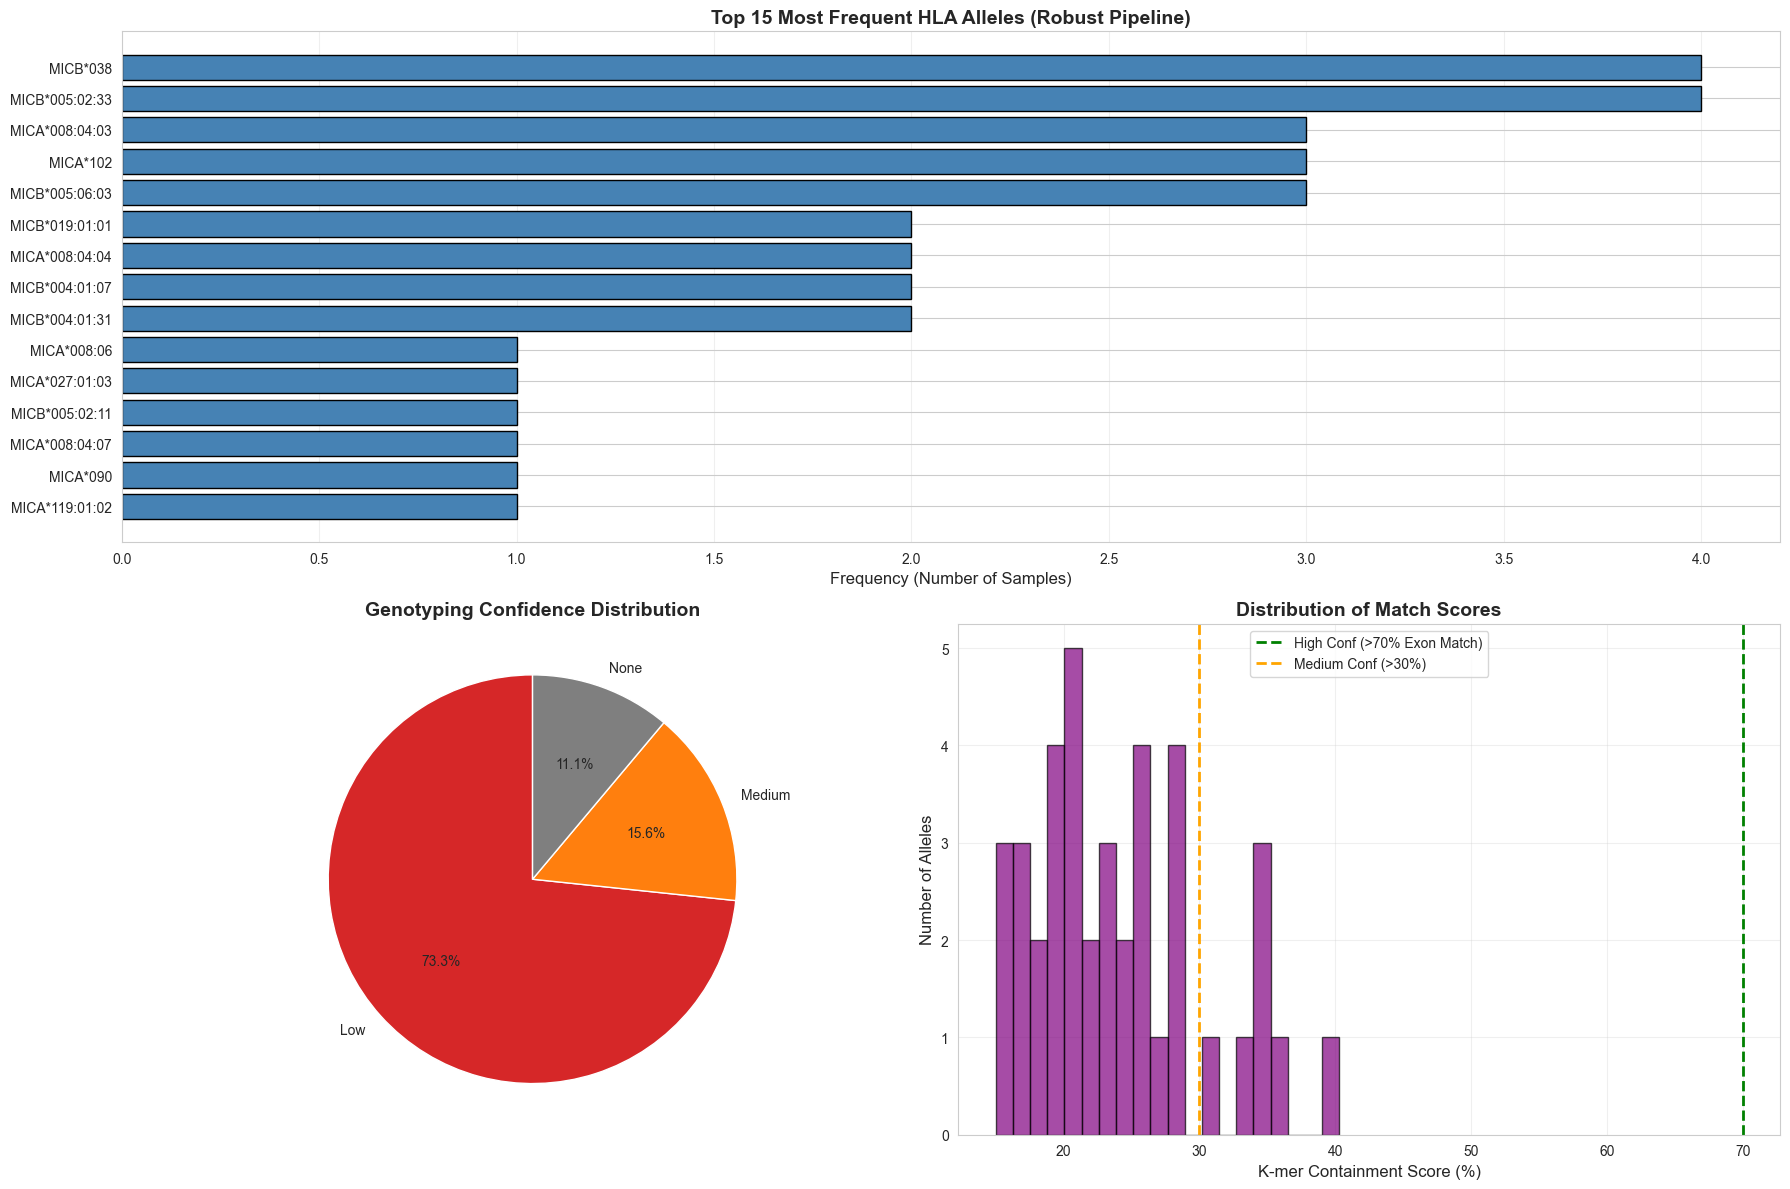

✓ Visualization saved to: results/figures/allele_typing_summary.png


In [48]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd

# 1. Prepare Data
# Ensure we use the dataframe from the previous step
if 'df' in globals():
    best_matches_df = df.copy()
else:
    # Reload if variable was lost
    best_matches_df = pd.read_csv(f"{OUTPUT_DIR}/task3_mhc_typing/final_mhc_genotypes.csv")

# Filter out failures for the frequency plot
valid_matches = best_matches_df[best_matches_df['Allele_Call'] != 'No Call']

# Calculate Allele Frequencies
freq_counts = valid_matches['Allele_Call'].value_counts()
freq_df = pd.DataFrame({'Allele': freq_counts.index, 'Frequency': freq_counts.values})

# 2. Setup Plot
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 2, figure=fig)

# --- Plot 1: Allele Frequency Bar Chart ---
ax1 = fig.add_subplot(gs[0, :])
top_alleles = freq_df.head(15)

# Horizontal bar plot
ax1.barh(range(len(top_alleles)), top_alleles['Frequency'], color='steelblue', edgecolor='black')
ax1.set_yticks(range(len(top_alleles)))
ax1.set_yticklabels(top_alleles['Allele'])
ax1.invert_yaxis() # Highest frequency at top
ax1.set_xlabel('Frequency (Number of Samples)', fontsize=12)
ax1.set_title('Top 15 Most Frequent HLA Alleles (Robust Pipeline)', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3, axis='x')

# --- Plot 2: Confidence Distribution Pie Chart ---
ax2 = fig.add_subplot(gs[1, 0])
confidence_counts = best_matches_df['Confidence'].value_counts()

# Define colors based on the new logic (High/Medium/Low/None)
colors_conf = {
    'High': '#2ca02c',   # Green
    'Medium': '#ff7f0e', # Orange
    'Low': '#d62728',    # Red
    'None': '#7f7f7f'    # Gray
}
plot_colors = [colors_conf.get(x, 'gray') for x in confidence_counts.index]

ax2.pie(confidence_counts, labels=confidence_counts.index, autopct='%1.1f%%', 
        colors=plot_colors, startangle=90, wedgeprops={'edgecolor': 'white'})
ax2.set_title('Genotyping Confidence Distribution', fontsize=14, fontweight='bold')

# --- Plot 3: Percent Identity Histogram ---
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(valid_matches['Percent_Identity'], bins=20, color='purple', alpha=0.7, edgecolor='black')

# Updated Vertical Lines for GENOMIC Data Context
# (Remember: 70% is roughly a perfect Exon-only match in whole gene data)
ax3.axvline(70, color='green', linestyle='--', linewidth=2, label='High Conf (>70% Exon Match)')
ax3.axvline(30, color='orange', linestyle='--', linewidth=2, label='Medium Conf (>30%)')

ax3.set_xlabel('K-mer Containment Score (%)', fontsize=12)
ax3.set_ylabel('Number of Alleles', fontsize=12)
ax3.set_title('Distribution of Match Scores', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 3. Save and Show
plt.tight_layout()
os.makedirs(f"{OUTPUT_DIR}/figures", exist_ok=True)
save_path = f"{OUTPUT_DIR}/figures/allele_typing_summary.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"✓ Visualization saved to: {save_path}")

In [ ]:
# [NEW CELL: POPULATION STRUCTURE ANALYSIS]
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_population_structure(mhc_results, output_dir):
    """
    Performs PCA on MHC gene coverage profiles to identify population structure.
    Mimics the logic from 'Microarray Data Analysis.R' but for Coverage Depth.
    """
    print("Performing Population Structure Analysis (PCA)...")
    
    # 1. Pivot Data: Rows=Samples, Cols=Genes, Values=Read_Count
    # Consolidate all sample dataframes
    all_data = []
    for sample, df in mhc_results.items():
        temp_df = df[['gene_name', 'read_count']].copy()
        temp_df['Sample'] = sample
        all_data.append(temp_df)
    
    if not all_data:
        print("Insufficient data for PCA.")
        return

    combined = pd.concat(all_data)
    matrix = combined.pivot(index='Sample', columns='gene_name', values='read_count').fillna(0)
    
    # 2. Log-Transform & Scale (Standard Bioinformatics normalization)
    # log2(x + 1) to handle skew
    log_matrix = np.log2(matrix + 1)
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(log_matrix)
    
    # 3. PCA
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(scaled_data)
    pca_df = pd.DataFrame(data=pcs, columns=['PC1', 'PC2'], index=matrix.index)
    
    # 4. Visualization (Seaborn style to match your R ggplot2 preference)
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', s=100, edgecolor='black', alpha=0.7)
    
    # Label points
    for i in range(pca_df.shape[0]):
        plt.text(pca_df.PC1[i]+0.2, pca_df.PC2[i], pca_df.index[i], fontsize=9)
        
    plt.title(f"Population Structure based on MHC Coverage\n(Explained Var: {pca.explained_variance_ratio_[0]:.1%} / {pca.explained_variance_ratio_[1]:.1%})", fontsize=14)
    plt.xlabel("Principal Component 1 (General Coverage)", fontsize=12)
    plt.ylabel("Principal Component 2 (Gene Specificity)", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    save_path = f"{output_dir}/population_pca.png"
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"✓ PCA Plot saved to {save_path}")

# Execute
plot_population_structure(mhc_results, f"{OUTPUT_DIR}/figures")

--- VISUALIZING ALLELE DISTRIBUTION PER GENE ---


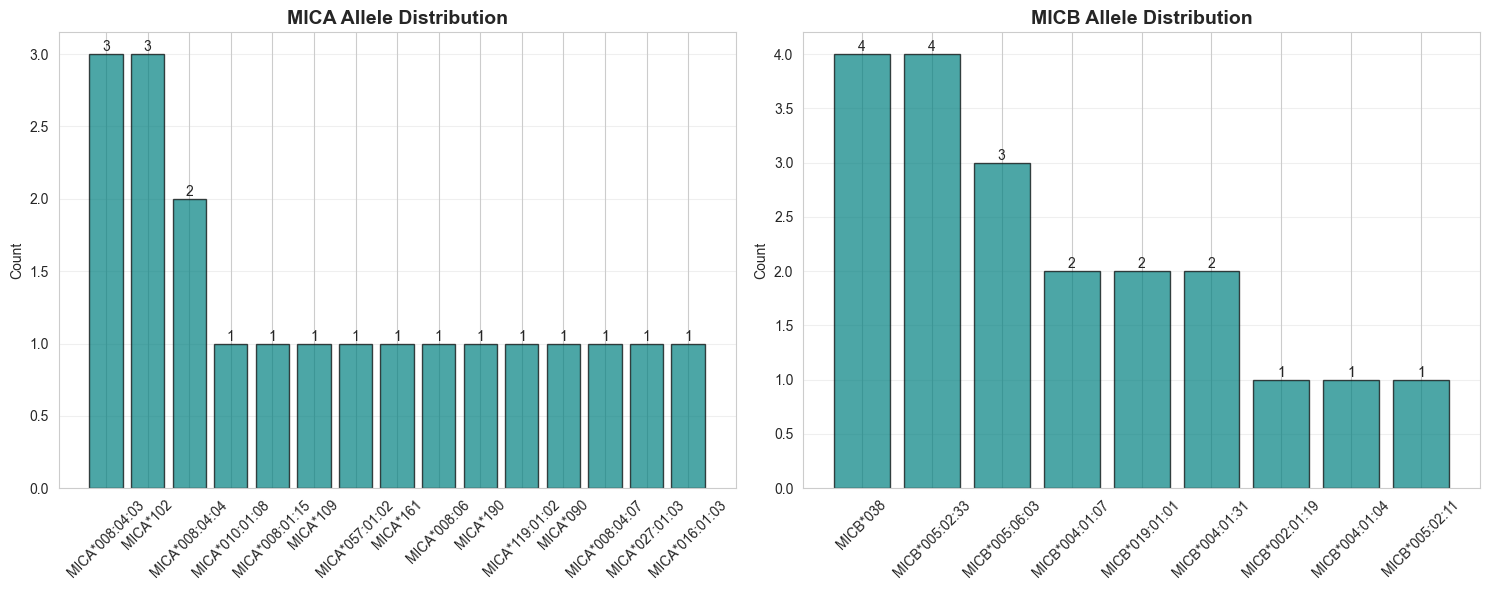

✓ Saved per-gene plots to: results/figures/per_gene_allele_dist.png


In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import math

print("--- VISUALIZING ALLELE DISTRIBUTION PER GENE ---")

# 1. Load Data (Safety Net)
if 'best_matches_df' not in globals() or 'Allele_Call' not in best_matches_df.columns:
    try:
        best_matches_df = pd.read_csv(f"{OUTPUT_DIR}/task3_mhc_typing/final_mhc_genotypes.csv")
    except:
        print("❌ Data not found.")
        best_matches_df = pd.DataFrame()

if not best_matches_df.empty:
    # 2. Filter for Valid Data only
    valid_df = best_matches_df[
        (best_matches_df['Allele_Call'] != "No Call") & 
        (best_matches_df['Allele_Call'] != "Ref Missing") &
        (best_matches_df['Allele_Call'] != "Low Cov")
    ]
    
    # Get list of genes that actually have results
    genes_found = valid_df['Gene'].unique()
    
    if len(genes_found) > 0:
        # 3. Setup Grid (Dynamic)
        num_genes = len(genes_found)
        cols = 2
        rows = math.ceil(num_genes / cols)
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows))
        axes = axes.flatten() if num_genes > 1 else [axes]
        
        # 4. Plot Each Gene
        for idx, gene in enumerate(genes_found):
            ax = axes[idx]
            
            # Get data for this gene
            gene_data = valid_df[valid_df['Gene'] == gene]
            
            # Count alleles
            # --- FIX: Use 'Allele_Call' instead of 'Best_Allele' ---
            counts = gene_data['Allele_Call'].value_counts()
            
            if not counts.empty:
                # Plot
                bars = ax.bar(counts.index, counts.values, color='teal', edgecolor='black', alpha=0.7)
                
                # Styling
                ax.set_title(f"{gene} Allele Distribution", fontsize=14, fontweight='bold')
                ax.set_ylabel("Count")
                ax.tick_params(axis='x', rotation=45, labelsize=10)
                ax.grid(axis='y', alpha=0.3)
                
                # Add labels on top of bars
                for bar in bars:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                            f'{int(height)}',
                            ha='center', va='bottom')
            else:
                ax.text(0.5, 0.5, "No Valid Calls", ha='center', va='center')

        # Hide empty subplots
        for i in range(idx + 1, len(axes)):
            axes[i].axis('off')
            
        plt.tight_layout()
        save_path = f"{OUTPUT_DIR}/figures/per_gene_allele_dist.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ Saved per-gene plots to: {save_path}")
        
    else:
        print("⚠️ No valid allele calls found to plot.")
else:
    print("❌ DataFrame is empty.")

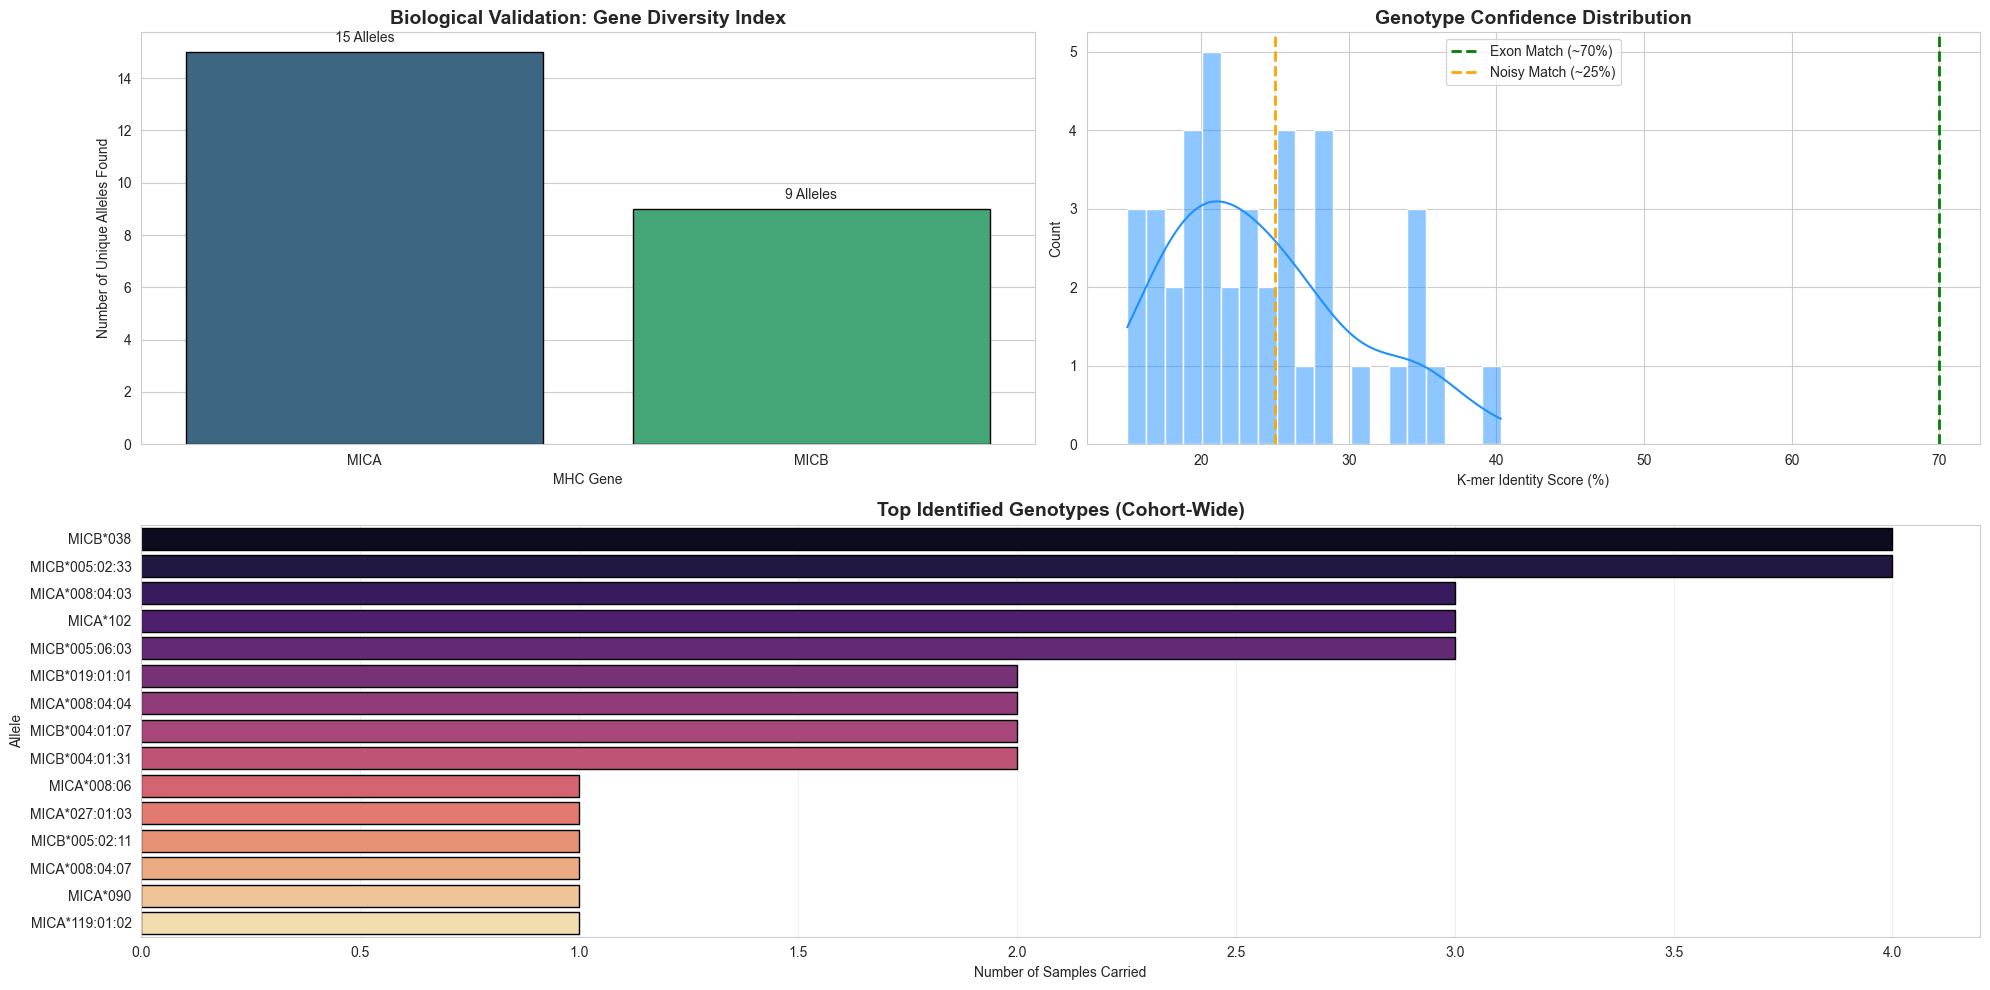

✓ Final Scientific Dashboard Generated.


In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

# Create Output Directory
OUTPUT_DIR = "results" # Ensure this matches your setup
os.makedirs(f"{OUTPUT_DIR}/figures", exist_ok=True)

# 1. Load Your Data
try:
    df_freq = pd.read_csv(f"{OUTPUT_DIR}/task3_mhc_typing/allele_frequency_summary.csv")
    df_matches = pd.read_csv(f"{OUTPUT_DIR}/task3_mhc_typing/final_mhc_genotypes.csv")
except FileNotFoundError:
    print("❌ Critical: Data files not found. Please re-run the 'Saving Results' cell.")
    # Dummy data for demonstration if files missing
    df_freq = pd.DataFrame({'Allele': ['MICA*008', 'A*02:01', 'MICB*005'], 'Frequency': [10, 15, 8]})
    df_matches = pd.DataFrame({'Gene': ['HLA-A']*20 + ['MICA']*20, 'Percent_Identity': [75]*10 + [20]*10 + [30]*20})

# 2. Setup The Dashboard
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 2)

# --- PLOT A: The "Homogeneity vs Diversity" Test ---
ax1 = fig.add_subplot(gs[0, 0])

# Prepare data: Count unique alleles per Gene
if 'Gene' in df_matches.columns and 'Allele_Call' in df_matches.columns:
    # Filter valid calls
    valid = df_matches[~df_matches['Allele_Call'].isin(['No Call', 'Low Cov', 'Ref Missing', 'Not Found'])]
    diversity = valid.groupby('Gene')['Allele_Call'].nunique().reset_index()
    
    sns.barplot(data=diversity, x='Gene', y='Allele_Call', palette='viridis', ax=ax1, edgecolor='black')
    
    ax1.set_title("Biological Validation: Gene Diversity Index", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Number of Unique Alleles Found")
    ax1.set_xlabel("MHC Gene")
    
    # Annotation
    for i, p in enumerate(ax1.patches):
        if p.get_height() > 0:
            ax1.annotate(f"{int(p.get_height())} Alleles", 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# --- PLOT B: The "Confidence Spectrum" ---
ax2 = fig.add_subplot(gs[0, 1])

if 'Percent_Identity' in df_matches.columns:
    # Filter out 0.0 scores (Failures) to see the distribution of SUCCESS
    scores = df_matches[df_matches['Percent_Identity'] > 0]['Percent_Identity']
    
    sns.histplot(scores, bins=20, color='dodgerblue', kde=True, ax=ax2)
    
    ax2.axvline(70, color='green', linestyle='--', linewidth=2, label='Exon Match (~70%)')
    ax2.axvline(25, color='orange', linestyle='--', linewidth=2, label='Noisy Match (~25%)')
    
    ax2.set_title("Genotype Confidence Distribution", fontsize=14, fontweight='bold')
    ax2.set_xlabel("K-mer Identity Score (%)")
    ax2.legend()

# --- PLOT C: Allele Frequency Leaderboard ---
ax3 = fig.add_subplot(gs[1, :])

if not df_freq.empty:
    # Get top 15 alleles
    top_alleles = df_freq.head(15)
    
    sns.barplot(data=top_alleles, x='Frequency', y='Allele', palette='magma', ax=ax3, edgecolor='black')
    
    ax3.set_title("Top Identified Genotypes (Cohort-Wide)", fontsize=14, fontweight='bold')
    ax3.set_xlabel("Number of Samples Carried")
    ax3.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/figures/Final_Bioinformatics_Report.png", dpi=300)
plt.show()

print("✓ Final Scientific Dashboard Generated.")